# LSGAN

In [1]:
import os

In [0]:
#from google.colab import drive
#absdrive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#ls /content/drive/'My Drive'/'Colab Notebooks'

In [3]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.utils
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os

In [4]:
batch_size=32
num_workers=1
lr = 0.01
beta1 = 0.5
nz = 100
n_epoch=200

In [5]:
# define Generator
class Generator(nn.Module):
  def __init__(self, nz=100, nch_g=64, nch=3):
    """
    nz: # of dimension of input vector
    nch_g: # of input channels at last layer
    nch: # of output channels
    """
    super(Generator, self).__init__()

    # define network
    self.layers = nn.ModuleList([
                                 nn.Sequential(
                                     nn.ConvTranspose2d(nz, nch_g * 8, 4, 1, 0),
                                     nn.BatchNorm2d(nch_g*8),
                                     nn.ReLU()
                                 ),
                                 nn.Sequential(
                                     nn.ConvTranspose2d(nch_g * 8, nch_g * 4, 4, 2, 1),
                                     nn.BatchNorm2d(nch_g * 4),
                                     nn.ReLU()                                     
                                 ),
                                nn.Sequential(
                                     nn.ConvTranspose2d(nch_g * 4, nch_g * 2, 4, 2, 1),
                                     nn.BatchNorm2d(nch_g * 2),
                                     nn.ReLU()                                     
                                 ),
                                nn.Sequential(
                                     nn.ConvTranspose2d(nch_g * 2, nch_g, 4, 2, 1),
                                     nn.BatchNorm2d(nch_g),
                                     nn.ReLU()                                     
                                 ),
                                 nn.Sequential(
                                     nn.ConvTranspose2d(nch_g, nch, 4, 2, 1),
                                     nn.BatchNorm2d(nch),
                                     nn.Tanh()                                    
                                 ) 
    ])

  def forward(self, z):
    """
    z: input vector
    return generated image
    """
    for layer in self.layers:
      z = layer(z)
    return z



In [6]:
class Discriminator(nn.Module):
  def __init__(self, nch=3, nch_d=64):
    super(Discriminator, self).__init__()

    # define network
    self.layers = nn.ModuleList([
                                 nn.Sequential(
                                     nn.Conv2d(nch, nch_d, 4, 2, 1),
                                     nn.LeakyReLU(negative_slope=0.2)                                    
                                 ),
                                 nn.Sequential(
                                     nn.Conv2d(nch_d, nch_d*2, 4, 2,1),
                                     nn.BatchNorm2d(nch_d*2),
                                     nn.LeakyReLU(negative_slope=0.2)                                    
                                 ),
                                 nn.Sequential(
                                     nn.Conv2d(nch_d*2, nch_d*4, 4, 2,1),
                                     nn.BatchNorm2d(nch_d*4),
                                     nn.LeakyReLU(negative_slope=0.2)                                    
                                 ),
                                 nn.Sequential(
                                     nn.Conv2d(nch_d*4, nch_d*8, 4, 2,1),
                                     nn.BatchNorm2d(nch_d*8),
                                     nn.LeakyReLU(negative_slope=0.2)                                    
                                 ),
                                 nn.Conv2d(nch_d*8, 1, 4, 1, 0)
    ])

  def forward(self, z):
    """
    z: input vector
    return generated image
    """
    for layer in self.layers:
      z = layer(z)
    return z
  

In [7]:
# define model
device = 'cuda' if torch.cuda.is_available() else 'cpu'

netG = Generator()
netG = netG.to(device)

netD = Discriminator()
netD = netD.to(device)
#criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)



In [8]:
device

'cuda'

In [9]:
netG

Generator(
  (layers): ModuleList(
    (0): Sequential(
      (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1))
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (3): Sequential(
      (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (4): Sequential(
      (0): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(

In [10]:
netD

Discriminator(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.2)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (3): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (4): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1))
  )
)

In [11]:
# load STL-10 training dataset
trainset = torchvision.datasets.STL10(root='stl10_root', download=True, split='train+unlabeled',
                                      transform=transforms.Compose([
                                                                    transforms.RandomResizedCrop(64, scale=(88/96, 1.0), ratio=(1.,1.)),
                                                                    transforms.ColorJitter(brightness=0.05, contrast=0.05, saturation=0.05, hue=0.05),
                                                                    transforms.ToTensor(),
                                                                    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))

                                      ])
                                      )


testset = torchvision.datasets.STL10(root='stl10_root', download=True, split='test',
                                      transform=transforms.Compose([
                                                                    transforms.RandomResizedCrop(64, scale=(88/96, 1.0), ratio=(1.,1.)),
                                                                    transforms.ColorJitter(brightness=0.05, contrast=0.05, saturation=0.05, hue=0.05),
                                                                    transforms.ToTensor(),
                                                                    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))

                                      ])
                                      )

dataset = trainset + testset # combined dataset is used as training data

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=int(num_workers))

100.0%

Extracting stl10_root\stl10_binary.tar.gz to stl10_root
Files already downloaded and verified


In [12]:
# loss function and optimizer
criterion = nn.MSELoss()

optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999), weight_decay=1e-5)

optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999), weight_decay=1e-5)

fixed_noise= torch.randn(batch_size, nz, 1, 1, device=device)

# Training


In [13]:
outf="sec6_out"
os.mkdir(outf)

FileExistsError: [WinError 183] 既に存在するファイルを作成することはできません。: 'sec6_out'

In [14]:
ls 

 ドライブ F のボリューム ラベルは ボリューム です
 ボリューム シリアル番号は B477-D413 です

 F:\ml\pytorch_handbook のディレクトリ

2020/01/26  13:46    <DIR>          .
2020/01/26  13:46    <DIR>          ..
2020/01/26  11:58    <DIR>          .ipynb_checkpoints
2020/01/26  13:46           211,445 PytorchHandbook_chap6_1.ipynb
2019/11/15  17:48                 5 README.md
2019/11/15  18:19             5,478 sec1.ipynb
2020/01/26  11:57    <DIR>          sec6_out
2020/01/26  13:16    <DIR>          stl10_root
2019/11/15  18:10                72 Untitled.ipynb
               4 個のファイル             217,000 バイト
               5 個のディレクトリ  6,613,017,468,928 バイトの空き領域


In [15]:
for epoch in range(n_epoch):
  for itr, data in enumerate(dataloader):
    real_image = data[0].to(device)
    sample_size = real_image.size(0)
    print(sample_size)
    break
  break

32


In [16]:
#outf="/content/drive/My Drive/Colab Notebooks/pytorch_handbook"



# training
for epoch in range(n_epoch):
  for itr, data in enumerate(dataloader):
    real_image = data[0].to(device)
    sample_size = real_image.size(0)

    noise = torch.randn(sample_size, nz, 1, 1, device=device)

    real_target = torch.full((sample_size,), 1., device=device)
    fake_target = torch.full((sample_size,), 0., device=device)

    ################################
    # update netD
    ################################
    netD.zero_grad()

    output = netD(real_image)
    errD_real = criterion(output, real_target)

    D_x = output.mean().item()

    fake_image = netG(noise)

    output = netD(fake_image.detach())

    errD_fake = criterion(output, fake_target)

    D_G_z1 = output.mean().item()


    errD = errD_real + errD_fake

    errD.backward()

    optimizerD.step()

    ################################
    # update netG
    ################################
    netG.zero_grad()

    output = netD(fake_image)
    errG = criterion(output, real_target)
    D_G_z2 = output.mean().item()

    errG.backward()
    optimizerG.step()

    ################################
    # show current status
    ################################
    if itr%100==0:
      print('[{}/{}][{}/{}] Loss_D:{:.3f} Loss_G:{:.3f} D(x):{:.3f} D(G(z)):{:.3f}/{:.3f}'.format(
        epoch+1, n_epoch, itr + 1, len(dataloader), errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

    if epoch==0 and itr==0:
      torchvision.utils.save_image(real_image, '{}/real_samples.png'.format(outf), normalize=True, nrow=10)

  # output fake image per epch
  fake_image = netG(fixed_noise)
  torchvision.utils.save_image(fake_image.detach(), 
                               '{}/fake_samples_epoch_{:03d}.png'.format(outf, epoch+1), 
                               normalize=True, 
                               nrow=10)


C:\MyApp\anaconda3\envs\torch\lib\site-packages\torch\nn\modules\loss.py:431: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[1/200][1/3532] Loss_D:1.177 Loss_G:1335.855 D(x):0.096 D(G(z)):0.019/37.320
[1/200][101/3532] Loss_D:0.266 Loss_G:0.576 D(x):0.695 D(G(z)):0.032/0.309
[1/200][201/3532] Loss_D:1.000 Loss_G:0.814 D(x):0.496 D(G(z)):-0.222/0.493
[1/200][301/3532] Loss_D:0.625 Loss_G:0.563 D(x):0.495 D(G(z)):0.187/0.353
[1/200][401/3532] Loss_D:0.506 Loss_G:1.342 D(x):0.986 D(G(z)):0.397/-0.067
[1/200][501/3532] Loss_D:0.265 Loss_G:0.622 D(x):0.805 D(G(z)):0.397/0.229
[1/200][601/3532] Loss_D:0.205 Loss_G:0.332 D(x):0.861 D(G(z)):-0.146/0.458
[1/200][701/3532] Loss_D:0.172 Loss_G:0.850 D(x):0.845 D(G(z)):0.212/0.099
[1/200][801/3532] Loss_D:0.130 Loss_G:0.738 D(x):0.801 D(G(z)):0.176/0.151
[1/200][901/3532] Loss_D:0.782 Loss_G:0.569 D(x):0.734 D(G(z)):0.236/0.498
[1/200][1001/3532] Loss_D:0.437 Loss_G:0.400 D(x):0.471 D(G(z)):0.318/0.392
[1/200][1101/3532] Loss_D:0.454 Loss_G:0.402 D(x):0.516 D(G(z)):0.401/0.379
[1/200][1201/3532] Loss_D:0.608 Loss_G:0.533 D(x):0.490 D(G(z)):0.451/0.301
[1/200][1301/3532

C:\MyApp\anaconda3\envs\torch\lib\site-packages\torch\nn\modules\loss.py:431: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[2/200][1/3532] Loss_D:0.696 Loss_G:0.267 D(x):0.309 D(G(z)):0.239/0.604
[2/200][101/3532] Loss_D:0.377 Loss_G:0.486 D(x):0.584 D(G(z)):0.367/0.344
[2/200][201/3532] Loss_D:0.405 Loss_G:0.436 D(x):0.515 D(G(z)):0.350/0.356
[2/200][301/3532] Loss_D:0.579 Loss_G:0.648 D(x):0.626 D(G(z)):0.625/0.234
[2/200][401/3532] Loss_D:0.545 Loss_G:0.881 D(x):0.706 D(G(z)):0.495/0.144
[2/200][501/3532] Loss_D:0.479 Loss_G:0.300 D(x):0.480 D(G(z)):0.374/0.514
[2/200][601/3532] Loss_D:0.491 Loss_G:0.364 D(x):0.546 D(G(z)):0.395/0.415
[2/200][701/3532] Loss_D:0.443 Loss_G:0.302 D(x):0.538 D(G(z)):0.419/0.484
[2/200][801/3532] Loss_D:0.473 Loss_G:0.440 D(x):0.447 D(G(z)):0.248/0.369
[2/200][901/3532] Loss_D:0.536 Loss_G:0.719 D(x):0.568 D(G(z)):0.502/0.167
[2/200][1001/3532] Loss_D:0.621 Loss_G:0.171 D(x):0.381 D(G(z)):0.359/0.622
[2/200][1101/3532] Loss_D:0.572 Loss_G:0.217 D(x):0.392 D(G(z)):0.335/0.562
[2/200][1201/3532] Loss_D:1.313 Loss_G:0.313 D(x):0.130 D(G(z)):-0.109/0.738
[2/200][1301/3532] Loss

[5/200][101/3532] Loss_D:0.540 Loss_G:0.319 D(x):0.553 D(G(z)):0.561/0.446
[5/200][201/3532] Loss_D:0.552 Loss_G:0.306 D(x):0.451 D(G(z)):0.473/0.454
[5/200][301/3532] Loss_D:0.544 Loss_G:0.332 D(x):0.566 D(G(z)):0.565/0.434
[5/200][401/3532] Loss_D:0.437 Loss_G:0.357 D(x):0.564 D(G(z)):0.480/0.407
[5/200][501/3532] Loss_D:0.472 Loss_G:0.356 D(x):0.545 D(G(z)):0.475/0.423
[5/200][601/3532] Loss_D:0.496 Loss_G:0.391 D(x):0.552 D(G(z)):0.515/0.385
[5/200][701/3532] Loss_D:0.552 Loss_G:0.422 D(x):0.533 D(G(z)):0.529/0.371
[5/200][801/3532] Loss_D:0.456 Loss_G:0.467 D(x):0.536 D(G(z)):0.422/0.343
[5/200][901/3532] Loss_D:0.589 Loss_G:0.123 D(x):0.324 D(G(z)):0.319/0.661
[5/200][1001/3532] Loss_D:0.478 Loss_G:0.363 D(x):0.599 D(G(z)):0.502/0.425
[5/200][1101/3532] Loss_D:0.652 Loss_G:0.194 D(x):0.374 D(G(z)):0.322/0.713
[5/200][1201/3532] Loss_D:0.516 Loss_G:0.331 D(x):0.512 D(G(z)):0.440/0.447
[5/200][1301/3532] Loss_D:0.623 Loss_G:0.244 D(x):0.484 D(G(z)):0.526/0.530
[5/200][1401/3532] Lo

[8/200][201/3532] Loss_D:0.524 Loss_G:0.181 D(x):0.387 D(G(z)):0.376/0.579
[8/200][301/3532] Loss_D:0.472 Loss_G:0.359 D(x):0.505 D(G(z)):0.471/0.408
[8/200][401/3532] Loss_D:0.509 Loss_G:0.356 D(x):0.587 D(G(z)):0.575/0.406
[8/200][501/3532] Loss_D:0.833 Loss_G:0.778 D(x):0.901 D(G(z)):0.906/0.119
[8/200][601/3532] Loss_D:0.519 Loss_G:0.270 D(x):0.486 D(G(z)):0.494/0.483
[8/200][701/3532] Loss_D:0.509 Loss_G:0.333 D(x):0.568 D(G(z)):0.565/0.424
[8/200][801/3532] Loss_D:0.535 Loss_G:0.179 D(x):0.370 D(G(z)):0.364/0.584
[8/200][901/3532] Loss_D:0.650 Loss_G:0.043 D(x):0.245 D(G(z)):0.213/0.807
[8/200][1001/3532] Loss_D:0.521 Loss_G:0.283 D(x):0.523 D(G(z)):0.533/0.471
[8/200][1101/3532] Loss_D:0.545 Loss_G:0.282 D(x):0.484 D(G(z)):0.516/0.473
[8/200][1201/3532] Loss_D:0.529 Loss_G:0.252 D(x):0.471 D(G(z)):0.489/0.501
[8/200][1301/3532] Loss_D:0.480 Loss_G:0.294 D(x):0.431 D(G(z)):0.383/0.465
[8/200][1401/3532] Loss_D:0.472 Loss_G:0.340 D(x):0.500 D(G(z)):0.464/0.422
[8/200][1501/3532] L

[11/200][201/3532] Loss_D:0.461 Loss_G:0.197 D(x):0.448 D(G(z)):0.135/0.614
[11/200][301/3532] Loss_D:0.415 Loss_G:0.491 D(x):0.487 D(G(z)):0.255/0.316
[11/200][401/3532] Loss_D:0.381 Loss_G:0.692 D(x):0.600 D(G(z)):0.391/0.178
[11/200][501/3532] Loss_D:0.460 Loss_G:0.586 D(x):0.522 D(G(z)):0.437/0.245
[11/200][601/3532] Loss_D:0.420 Loss_G:0.388 D(x):0.425 D(G(z)):0.215/0.390
[11/200][701/3532] Loss_D:0.308 Loss_G:0.595 D(x):0.501 D(G(z)):0.044/0.238
[11/200][801/3532] Loss_D:0.322 Loss_G:0.968 D(x):0.694 D(G(z)):0.420/0.027
[11/200][901/3532] Loss_D:0.406 Loss_G:0.653 D(x):0.461 D(G(z)):0.184/0.196
[11/200][1001/3532] Loss_D:0.412 Loss_G:1.075 D(x):0.994 D(G(z)):0.587/-0.032
[11/200][1101/3532] Loss_D:0.318 Loss_G:0.574 D(x):0.556 D(G(z)):0.199/0.254
[11/200][1201/3532] Loss_D:0.331 Loss_G:0.594 D(x):0.677 D(G(z)):0.386/0.241
[11/200][1301/3532] Loss_D:0.403 Loss_G:0.497 D(x):0.471 D(G(z)):0.286/0.307
[11/200][1401/3532] Loss_D:0.398 Loss_G:1.051 D(x):0.727 D(G(z)):0.508/-0.017
[11/2

[14/200][101/3532] Loss_D:0.525 Loss_G:0.205 D(x):0.451 D(G(z)):0.465/0.553
[14/200][201/3532] Loss_D:0.514 Loss_G:0.403 D(x):0.563 D(G(z)):0.562/0.368
[14/200][301/3532] Loss_D:0.531 Loss_G:0.283 D(x):0.479 D(G(z)):0.497/0.471
[14/200][401/3532] Loss_D:0.493 Loss_G:0.308 D(x):0.448 D(G(z)):0.412/0.454
[14/200][501/3532] Loss_D:0.597 Loss_G:0.261 D(x):0.425 D(G(z)):0.485/0.494
[14/200][601/3532] Loss_D:0.480 Loss_G:0.525 D(x):0.606 D(G(z)):0.538/0.285
[14/200][701/3532] Loss_D:0.546 Loss_G:0.603 D(x):0.711 D(G(z)):0.669/0.226
[14/200][801/3532] Loss_D:0.455 Loss_G:0.266 D(x):0.455 D(G(z)):0.359/0.496
[14/200][901/3532] Loss_D:0.640 Loss_G:0.418 D(x):0.771 D(G(z)):0.764/0.355
[14/200][1001/3532] Loss_D:0.579 Loss_G:0.269 D(x):0.449 D(G(z)):0.479/0.491
[14/200][1101/3532] Loss_D:0.517 Loss_G:0.510 D(x):0.635 D(G(z)):0.597/0.296
[14/200][1201/3532] Loss_D:0.462 Loss_G:0.252 D(x):0.473 D(G(z)):0.393/0.508
[14/200][1301/3532] Loss_D:0.573 Loss_G:0.340 D(x):0.298 D(G(z)):0.255/0.427
[14/200]

[17/200][1/3532] Loss_D:1.507 Loss_G:0.057 D(x):-0.155 D(G(z)):-0.271/1.160
[17/200][101/3532] Loss_D:0.472 Loss_G:0.358 D(x):0.606 D(G(z)):0.533/0.415
[17/200][201/3532] Loss_D:0.511 Loss_G:0.389 D(x):0.586 D(G(z)):0.553/0.386
[17/200][301/3532] Loss_D:0.524 Loss_G:0.436 D(x):0.641 D(G(z)):0.608/0.345
[17/200][401/3532] Loss_D:1.172 Loss_G:0.098 D(x):-0.014 D(G(z)):-0.046/1.002
[17/200][501/3532] Loss_D:0.493 Loss_G:0.293 D(x):0.509 D(G(z)):0.462/0.470
[17/200][601/3532] Loss_D:1.117 Loss_G:0.053 D(x):0.020 D(G(z)):0.032/1.051
[17/200][701/3532] Loss_D:0.657 Loss_G:0.117 D(x):0.225 D(G(z)):0.164/0.678
[17/200][801/3532] Loss_D:0.570 Loss_G:0.111 D(x):0.345 D(G(z)):0.349/0.680
[17/200][901/3532] Loss_D:0.688 Loss_G:0.102 D(x):0.227 D(G(z)):0.239/0.695
[17/200][1001/3532] Loss_D:0.638 Loss_G:0.081 D(x):0.269 D(G(z)):0.261/0.733
[17/200][1101/3532] Loss_D:0.612 Loss_G:0.100 D(x):0.327 D(G(z)):0.362/0.707
[17/200][1201/3532] Loss_D:1.589 Loss_G:0.067 D(x):-0.212 D(G(z)):-0.220/1.136
[17/2

[19/200][3501/3532] Loss_D:1.615 Loss_G:0.376 D(x):-0.180 D(G(z)):-0.223/1.188
[20/200][1/3532] Loss_D:1.069 Loss_G:1.445 D(x):1.022 D(G(z)):0.986/-0.179
[20/200][101/3532] Loss_D:1.173 Loss_G:1.568 D(x):1.085 D(G(z)):1.056/-0.244
[20/200][201/3532] Loss_D:0.616 Loss_G:0.783 D(x):0.850 D(G(z)):0.755/0.132
[20/200][301/3532] Loss_D:0.550 Loss_G:0.575 D(x):0.603 D(G(z)):0.594/0.259
[20/200][401/3532] Loss_D:0.731 Loss_G:0.230 D(x):0.313 D(G(z)):0.308/0.721
[20/200][501/3532] Loss_D:0.507 Loss_G:0.490 D(x):0.639 D(G(z)):0.574/0.311
[20/200][601/3532] Loss_D:1.051 Loss_G:0.143 D(x):0.045 D(G(z)):-0.015/0.809
[20/200][701/3532] Loss_D:0.732 Loss_G:0.799 D(x):0.863 D(G(z)):0.812/0.129
[20/200][801/3532] Loss_D:0.664 Loss_G:0.700 D(x):0.750 D(G(z)):0.691/0.200
[20/200][901/3532] Loss_D:2.451 Loss_G:2.893 D(x):1.535 D(G(z)):1.444/-0.683
[20/200][1001/3532] Loss_D:0.406 Loss_G:0.416 D(x):0.588 D(G(z)):0.443/0.377
[20/200][1101/3532] Loss_D:1.460 Loss_G:0.141 D(x):-0.103 D(G(z)):-0.172/0.950
[20

[22/200][3401/3532] Loss_D:0.076 Loss_G:2.194 D(x):0.946 D(G(z)):0.078/-0.479
[22/200][3501/3532] Loss_D:0.294 Loss_G:0.401 D(x):0.833 D(G(z)):-0.430/0.373
[23/200][1/3532] Loss_D:0.437 Loss_G:2.878 D(x):1.246 D(G(z)):0.512/-0.696
[23/200][101/3532] Loss_D:0.357 Loss_G:0.245 D(x):0.808 D(G(z)):-0.439/0.547
[23/200][201/3532] Loss_D:0.066 Loss_G:1.232 D(x):0.929 D(G(z)):0.178/-0.105
[23/200][301/3532] Loss_D:0.094 Loss_G:1.054 D(x):0.822 D(G(z)):0.097/-0.001
[23/200][401/3532] Loss_D:0.314 Loss_G:0.585 D(x):0.610 D(G(z)):-0.259/0.242
[23/200][501/3532] Loss_D:0.571 Loss_G:1.602 D(x):0.786 D(G(z)):0.601/-0.262
[23/200][601/3532] Loss_D:0.068 Loss_G:1.239 D(x):1.005 D(G(z)):0.182/-0.111
[23/200][701/3532] Loss_D:0.076 Loss_G:0.891 D(x):0.895 D(G(z)):-0.181/0.058
[23/200][801/3532] Loss_D:0.125 Loss_G:1.297 D(x):0.977 D(G(z)):0.098/-0.129
[23/200][901/3532] Loss_D:0.089 Loss_G:0.706 D(x):0.776 D(G(z)):-0.018/0.180
[23/200][1001/3532] Loss_D:0.818 Loss_G:0.190 D(x):0.309 D(G(z)):-0.340/0.63

[25/200][3301/3532] Loss_D:0.300 Loss_G:1.086 D(x):0.779 D(G(z)):0.443/-0.032
[25/200][3401/3532] Loss_D:0.404 Loss_G:1.803 D(x):0.880 D(G(z)):0.551/-0.328
[25/200][3501/3532] Loss_D:0.434 Loss_G:0.397 D(x):0.438 D(G(z)):0.256/0.393
[26/200][1/3532] Loss_D:0.293 Loss_G:1.504 D(x):0.852 D(G(z)):0.441/-0.217
[26/200][101/3532] Loss_D:0.380 Loss_G:1.450 D(x):0.896 D(G(z)):0.545/-0.191
[26/200][201/3532] Loss_D:0.289 Loss_G:0.495 D(x):0.713 D(G(z)):0.391/0.306
[26/200][301/3532] Loss_D:0.270 Loss_G:0.564 D(x):0.628 D(G(z)):0.296/0.261
[26/200][401/3532] Loss_D:0.288 Loss_G:0.709 D(x):0.659 D(G(z)):0.341/0.170
[26/200][501/3532] Loss_D:0.211 Loss_G:0.843 D(x):0.694 D(G(z)):0.240/0.101
[26/200][601/3532] Loss_D:0.277 Loss_G:1.978 D(x):0.926 D(G(z)):0.443/-0.389
[26/200][701/3532] Loss_D:0.223 Loss_G:0.776 D(x):0.631 D(G(z)):0.161/0.126
[26/200][801/3532] Loss_D:0.462 Loss_G:1.524 D(x):0.771 D(G(z)):0.583/-0.224
[26/200][901/3532] Loss_D:0.439 Loss_G:0.368 D(x):0.400 D(G(z)):0.221/0.405
[26/2

[28/200][3201/3532] Loss_D:0.387 Loss_G:0.711 D(x):0.639 D(G(z)):0.466/0.169
[28/200][3301/3532] Loss_D:0.397 Loss_G:0.679 D(x):0.596 D(G(z)):0.451/0.181
[28/200][3401/3532] Loss_D:0.359 Loss_G:0.698 D(x):0.507 D(G(z)):0.262/0.175
[28/200][3501/3532] Loss_D:0.409 Loss_G:0.375 D(x):0.443 D(G(z)):0.211/0.401
[29/200][1/3532] Loss_D:0.542 Loss_G:0.615 D(x):0.369 D(G(z)):0.269/0.231
[29/200][101/3532] Loss_D:0.481 Loss_G:0.358 D(x):0.459 D(G(z)):0.358/0.410
[29/200][201/3532] Loss_D:0.346 Loss_G:0.386 D(x):0.572 D(G(z)):0.369/0.384
[29/200][301/3532] Loss_D:0.297 Loss_G:0.771 D(x):0.664 D(G(z)):0.398/0.132
[29/200][401/3532] Loss_D:0.320 Loss_G:0.613 D(x):0.628 D(G(z)):0.378/0.230
[29/200][501/3532] Loss_D:0.504 Loss_G:0.712 D(x):0.609 D(G(z)):0.525/0.163
[29/200][601/3532] Loss_D:0.517 Loss_G:1.012 D(x):1.011 D(G(z)):0.682/0.004
[29/200][701/3532] Loss_D:0.451 Loss_G:1.042 D(x):0.635 D(G(z)):0.497/-0.009
[29/200][801/3532] Loss_D:0.565 Loss_G:0.156 D(x):0.287 D(G(z)):0.064/0.635
[29/200][

[31/200][3101/3532] Loss_D:0.543 Loss_G:0.173 D(x):0.374 D(G(z)):0.377/0.590
[31/200][3201/3532] Loss_D:0.493 Loss_G:0.259 D(x):0.485 D(G(z)):0.468/0.496
[31/200][3301/3532] Loss_D:0.584 Loss_G:0.514 D(x):0.746 D(G(z)):0.711/0.290
[31/200][3401/3532] Loss_D:0.627 Loss_G:0.526 D(x):0.754 D(G(z)):0.739/0.276
[31/200][3501/3532] Loss_D:0.525 Loss_G:0.207 D(x):0.415 D(G(z)):0.419/0.548
[32/200][1/3532] Loss_D:0.482 Loss_G:0.266 D(x):0.472 D(G(z)):0.425/0.493
[32/200][101/3532] Loss_D:0.460 Loss_G:0.403 D(x):0.553 D(G(z)):0.498/0.369
[32/200][201/3532] Loss_D:0.502 Loss_G:0.239 D(x):0.459 D(G(z)):0.443/0.518
[32/200][301/3532] Loss_D:0.510 Loss_G:0.317 D(x):0.422 D(G(z)):0.405/0.438
[32/200][401/3532] Loss_D:0.595 Loss_G:0.515 D(x):0.653 D(G(z)):0.678/0.285
[32/200][501/3532] Loss_D:0.495 Loss_G:0.418 D(x):0.560 D(G(z)):0.532/0.359
[32/200][601/3532] Loss_D:0.496 Loss_G:0.697 D(x):0.687 D(G(z)):0.622/0.175
[32/200][701/3532] Loss_D:0.472 Loss_G:0.363 D(x):0.511 D(G(z)):0.468/0.402
[32/200][

[34/200][3001/3532] Loss_D:0.458 Loss_G:1.400 D(x):0.804 D(G(z)):0.600/-0.169
[34/200][3101/3532] Loss_D:0.494 Loss_G:0.156 D(x):0.423 D(G(z)):0.371/0.621
[34/200][3201/3532] Loss_D:0.466 Loss_G:0.312 D(x):0.409 D(G(z)):0.279/0.452
[34/200][3301/3532] Loss_D:0.331 Loss_G:0.536 D(x):0.574 D(G(z)):0.323/0.278
[34/200][3401/3532] Loss_D:0.452 Loss_G:0.945 D(x):0.743 D(G(z)):0.571/0.037
[34/200][3501/3532] Loss_D:0.858 Loss_G:1.624 D(x):1.164 D(G(z)):0.879/-0.265
[35/200][1/3532] Loss_D:0.497 Loss_G:0.836 D(x):0.766 D(G(z)):0.602/0.089
[35/200][101/3532] Loss_D:0.472 Loss_G:0.308 D(x):0.455 D(G(z)):0.373/0.461
[35/200][201/3532] Loss_D:0.568 Loss_G:0.399 D(x):0.291 D(G(z)):0.078/0.378
[35/200][301/3532] Loss_D:0.321 Loss_G:0.821 D(x):0.599 D(G(z)):0.348/0.101
[35/200][401/3532] Loss_D:0.448 Loss_G:1.133 D(x):0.904 D(G(z)):0.612/-0.056
[35/200][501/3532] Loss_D:0.466 Loss_G:0.664 D(x):0.533 D(G(z)):0.405/0.197
[35/200][601/3532] Loss_D:0.432 Loss_G:0.913 D(x):0.618 D(G(z)):0.477/0.064
[35/2

[37/200][2901/3532] Loss_D:0.437 Loss_G:0.298 D(x):0.497 D(G(z)):0.392/0.460
[37/200][3001/3532] Loss_D:0.424 Loss_G:0.345 D(x):0.473 D(G(z)):0.341/0.419
[37/200][3101/3532] Loss_D:0.491 Loss_G:0.379 D(x):0.465 D(G(z)):0.436/0.391
[37/200][3201/3532] Loss_D:0.400 Loss_G:0.612 D(x):0.570 D(G(z)):0.402/0.240
[37/200][3301/3532] Loss_D:0.407 Loss_G:1.180 D(x):0.718 D(G(z)):0.518/-0.067
[37/200][3401/3532] Loss_D:0.375 Loss_G:0.394 D(x):0.536 D(G(z)):0.359/0.378
[37/200][3501/3532] Loss_D:0.301 Loss_G:0.597 D(x):0.687 D(G(z)):0.382/0.237
[38/200][1/3532] Loss_D:0.332 Loss_G:0.644 D(x):0.578 D(G(z)):0.308/0.214
[38/200][101/3532] Loss_D:0.340 Loss_G:0.484 D(x):0.609 D(G(z)):0.390/0.315
[38/200][201/3532] Loss_D:0.360 Loss_G:0.976 D(x):0.795 D(G(z)):0.519/0.016
[38/200][301/3532] Loss_D:0.338 Loss_G:1.018 D(x):0.785 D(G(z)):0.493/0.004
[38/200][401/3532] Loss_D:0.295 Loss_G:0.723 D(x):0.545 D(G(z)):0.237/0.162
[38/200][501/3532] Loss_D:0.219 Loss_G:0.684 D(x):0.670 D(G(z)):0.255/0.184
[38/20

[40/200][2801/3532] Loss_D:0.584 Loss_G:0.162 D(x):0.331 D(G(z)):0.350/0.613
[40/200][2901/3532] Loss_D:0.537 Loss_G:0.347 D(x):0.511 D(G(z)):0.515/0.417
[40/200][3001/3532] Loss_D:0.516 Loss_G:0.271 D(x):0.486 D(G(z)):0.480/0.484
[40/200][3101/3532] Loss_D:0.471 Loss_G:0.369 D(x):0.521 D(G(z)):0.475/0.399
[40/200][3201/3532] Loss_D:0.553 Loss_G:0.478 D(x):0.688 D(G(z)):0.657/0.316
[40/200][3301/3532] Loss_D:0.565 Loss_G:0.421 D(x):0.506 D(G(z)):0.506/0.361
[40/200][3401/3532] Loss_D:0.604 Loss_G:0.501 D(x):0.704 D(G(z)):0.709/0.295
[40/200][3501/3532] Loss_D:0.504 Loss_G:0.375 D(x):0.627 D(G(z)):0.596/0.397
[41/200][1/3532] Loss_D:0.494 Loss_G:0.375 D(x):0.533 D(G(z)):0.519/0.392
[41/200][101/3532] Loss_D:0.522 Loss_G:0.249 D(x):0.495 D(G(z)):0.490/0.513
[41/200][201/3532] Loss_D:0.553 Loss_G:0.294 D(x):0.441 D(G(z)):0.444/0.464
[41/200][301/3532] Loss_D:0.505 Loss_G:0.222 D(x):0.416 D(G(z)):0.397/0.531
[41/200][401/3532] Loss_D:0.547 Loss_G:0.198 D(x):0.401 D(G(z)):0.416/0.558
[41/20

[43/200][2701/3532] Loss_D:0.539 Loss_G:0.184 D(x):0.444 D(G(z)):0.461/0.578
[43/200][2801/3532] Loss_D:0.511 Loss_G:0.450 D(x):0.626 D(G(z)):0.600/0.334
[43/200][2901/3532] Loss_D:0.489 Loss_G:0.255 D(x):0.501 D(G(z)):0.468/0.505
[43/200][3001/3532] Loss_D:0.500 Loss_G:0.251 D(x):0.494 D(G(z)):0.463/0.510
[43/200][3101/3532] Loss_D:0.564 Loss_G:0.388 D(x):0.645 D(G(z)):0.649/0.382
[43/200][3201/3532] Loss_D:0.874 Loss_G:0.022 D(x):0.084 D(G(z)):0.074/0.970
[43/200][3301/3532] Loss_D:0.504 Loss_G:0.251 D(x):0.487 D(G(z)):0.483/0.505
[43/200][3401/3532] Loss_D:0.494 Loss_G:0.425 D(x):0.582 D(G(z)):0.554/0.352
[43/200][3501/3532] Loss_D:0.558 Loss_G:0.140 D(x):0.332 D(G(z)):0.310/0.636
[44/200][1/3532] Loss_D:0.588 Loss_G:0.179 D(x):0.452 D(G(z)):0.509/0.587
[44/200][101/3532] Loss_D:0.550 Loss_G:0.463 D(x):0.642 D(G(z)):0.603/0.334
[44/200][201/3532] Loss_D:0.543 Loss_G:0.211 D(x):0.411 D(G(z)):0.379/0.555
[44/200][301/3532] Loss_D:0.515 Loss_G:0.449 D(x):0.588 D(G(z)):0.577/0.339
[44/2

[46/200][2601/3532] Loss_D:1.008 Loss_G:0.784 D(x):0.927 D(G(z)):0.977/0.119
[46/200][2701/3532] Loss_D:0.444 Loss_G:0.233 D(x):0.446 D(G(z)):0.313/0.544
[46/200][2801/3532] Loss_D:0.682 Loss_G:0.804 D(x):0.742 D(G(z)):0.753/0.114
[46/200][2901/3532] Loss_D:0.957 Loss_G:0.870 D(x):0.938 D(G(z)):0.962/0.072
[46/200][3001/3532] Loss_D:1.630 Loss_G:1.886 D(x):1.252 D(G(z)):1.229/-0.361
[46/200][3101/3532] Loss_D:0.560 Loss_G:0.409 D(x):0.554 D(G(z)):0.551/0.373
[46/200][3201/3532] Loss_D:0.505 Loss_G:0.271 D(x):0.518 D(G(z)):0.495/0.488
[46/200][3301/3532] Loss_D:0.494 Loss_G:0.377 D(x):0.568 D(G(z)):0.518/0.403
[46/200][3401/3532] Loss_D:0.853 Loss_G:0.037 D(x):0.099 D(G(z)):0.105/0.892
[46/200][3501/3532] Loss_D:0.565 Loss_G:0.463 D(x):0.614 D(G(z)):0.618/0.326
[47/200][1/3532] Loss_D:0.596 Loss_G:0.139 D(x):0.307 D(G(z)):0.215/0.695
[47/200][101/3532] Loss_D:0.643 Loss_G:0.182 D(x):0.263 D(G(z)):0.253/0.591
[47/200][201/3532] Loss_D:0.574 Loss_G:0.415 D(x):0.696 D(G(z)):0.667/0.365
[47

[49/200][2501/3532] Loss_D:0.998 Loss_G:1.046 D(x):0.857 D(G(z)):0.866/-0.004
[49/200][2601/3532] Loss_D:0.524 Loss_G:0.437 D(x):0.566 D(G(z)):0.548/0.351
[49/200][2701/3532] Loss_D:0.653 Loss_G:0.132 D(x):0.367 D(G(z)):0.286/0.737
[49/200][2801/3532] Loss_D:0.882 Loss_G:0.044 D(x):0.088 D(G(z)):0.054/0.866
[49/200][2901/3532] Loss_D:0.665 Loss_G:0.740 D(x):0.738 D(G(z)):0.729/0.157
[49/200][3001/3532] Loss_D:0.621 Loss_G:0.186 D(x):0.357 D(G(z)):0.352/0.612
[49/200][3101/3532] Loss_D:0.490 Loss_G:0.377 D(x):0.531 D(G(z)):0.456/0.401
[49/200][3201/3532] Loss_D:0.541 Loss_G:0.512 D(x):0.601 D(G(z)):0.588/0.303
[49/200][3301/3532] Loss_D:0.575 Loss_G:0.142 D(x):0.343 D(G(z)):0.289/0.653
[49/200][3401/3532] Loss_D:0.686 Loss_G:0.872 D(x):0.805 D(G(z)):0.781/0.070
[49/200][3501/3532] Loss_D:0.699 Loss_G:0.168 D(x):0.257 D(G(z)):0.310/0.622
[50/200][1/3532] Loss_D:1.144 Loss_G:1.252 D(x):0.931 D(G(z)):0.849/0.012
[50/200][101/3532] Loss_D:0.858 Loss_G:0.939 D(x):0.833 D(G(z)):0.884/0.043
[5

[52/200][2401/3532] Loss_D:0.433 Loss_G:0.619 D(x):0.633 D(G(z)):0.472/0.242
[52/200][2501/3532] Loss_D:0.683 Loss_G:0.426 D(x):0.576 D(G(z)):0.572/0.380
[52/200][2601/3532] Loss_D:0.547 Loss_G:0.419 D(x):0.504 D(G(z)):0.387/0.389
[52/200][2701/3532] Loss_D:0.429 Loss_G:0.579 D(x):0.647 D(G(z)):0.404/0.270
[52/200][2801/3532] Loss_D:0.551 Loss_G:0.288 D(x):0.546 D(G(z)):0.552/0.478
[52/200][2901/3532] Loss_D:0.490 Loss_G:0.550 D(x):0.553 D(G(z)):0.437/0.315
[52/200][3001/3532] Loss_D:0.669 Loss_G:0.269 D(x):0.453 D(G(z)):0.580/0.498
[52/200][3101/3532] Loss_D:0.544 Loss_G:0.308 D(x):0.399 D(G(z)):0.301/0.515
[52/200][3201/3532] Loss_D:0.576 Loss_G:0.547 D(x):0.550 D(G(z)):0.515/0.365
[52/200][3301/3532] Loss_D:0.502 Loss_G:0.345 D(x):0.458 D(G(z)):0.399/0.449
[52/200][3401/3532] Loss_D:0.585 Loss_G:0.630 D(x):0.625 D(G(z)):0.527/0.265
[52/200][3501/3532] Loss_D:0.478 Loss_G:0.354 D(x):0.471 D(G(z)):0.412/0.438
[53/200][1/3532] Loss_D:0.616 Loss_G:0.623 D(x):0.596 D(G(z)):0.584/0.285
[5

[55/200][2301/3532] Loss_D:0.342 Loss_G:0.424 D(x):0.541 D(G(z)):0.243/0.355
[55/200][2401/3532] Loss_D:0.319 Loss_G:0.731 D(x):0.567 D(G(z)):0.274/0.163
[55/200][2501/3532] Loss_D:0.340 Loss_G:0.546 D(x):0.561 D(G(z)):0.294/0.269
[55/200][2601/3532] Loss_D:0.253 Loss_G:0.539 D(x):0.660 D(G(z)):0.317/0.271
[55/200][2701/3532] Loss_D:0.353 Loss_G:0.386 D(x):0.670 D(G(z)):0.464/0.385
[55/200][2801/3532] Loss_D:0.503 Loss_G:0.070 D(x):0.390 D(G(z)):-0.112/0.795
[55/200][2901/3532] Loss_D:0.365 Loss_G:0.607 D(x):0.645 D(G(z)):0.449/0.229
[55/200][3001/3532] Loss_D:0.575 Loss_G:0.257 D(x):0.390 D(G(z)):0.177/0.502
[55/200][3101/3532] Loss_D:0.929 Loss_G:1.796 D(x):1.070 D(G(z)):0.123/-0.279
[55/200][3201/3532] Loss_D:0.751 Loss_G:0.483 D(x):0.635 D(G(z)):0.629/0.407
[55/200][3301/3532] Loss_D:0.762 Loss_G:0.211 D(x):0.296 D(G(z)):0.455/0.554
[55/200][3401/3532] Loss_D:0.610 Loss_G:0.231 D(x):0.516 D(G(z)):0.523/0.569
[55/200][3501/3532] Loss_D:0.535 Loss_G:0.279 D(x):0.566 D(G(z)):0.535/0.4

[58/200][2201/3532] Loss_D:0.492 Loss_G:0.345 D(x):0.546 D(G(z)):0.531/0.416
[58/200][2301/3532] Loss_D:0.483 Loss_G:0.231 D(x):0.470 D(G(z)):0.443/0.523
[58/200][2401/3532] Loss_D:0.522 Loss_G:0.409 D(x):0.619 D(G(z)):0.607/0.364
[58/200][2501/3532] Loss_D:0.499 Loss_G:0.268 D(x):0.518 D(G(z)):0.509/0.487
[58/200][2601/3532] Loss_D:0.501 Loss_G:0.281 D(x):0.516 D(G(z)):0.514/0.472
[58/200][2701/3532] Loss_D:0.504 Loss_G:0.305 D(x):0.522 D(G(z)):0.524/0.449
[58/200][2801/3532] Loss_D:0.506 Loss_G:0.236 D(x):0.477 D(G(z)):0.480/0.517
[58/200][2901/3532] Loss_D:0.576 Loss_G:0.149 D(x):0.312 D(G(z)):0.309/0.616
[58/200][3001/3532] Loss_D:0.495 Loss_G:0.232 D(x):0.452 D(G(z)):0.437/0.521
[58/200][3101/3532] Loss_D:0.494 Loss_G:0.282 D(x):0.504 D(G(z)):0.494/0.470
[58/200][3201/3532] Loss_D:0.784 Loss_G:0.893 D(x):0.885 D(G(z)):0.871/0.056
[58/200][3301/3532] Loss_D:0.500 Loss_G:0.267 D(x):0.517 D(G(z)):0.510/0.485
[58/200][3401/3532] Loss_D:0.507 Loss_G:0.432 D(x):0.601 D(G(z)):0.586/0.344

[61/200][2101/3532] Loss_D:0.096 Loss_G:0.797 D(x):0.844 D(G(z)):0.163/0.113
[61/200][2201/3532] Loss_D:0.216 Loss_G:0.971 D(x):0.755 D(G(z)):0.329/0.025
[61/200][2301/3532] Loss_D:0.230 Loss_G:0.719 D(x):0.646 D(G(z)):0.180/0.162
[61/200][2401/3532] Loss_D:0.297 Loss_G:0.592 D(x):0.505 D(G(z)):0.077/0.240
[61/200][2501/3532] Loss_D:0.303 Loss_G:0.378 D(x):0.500 D(G(z)):-0.077/0.397
[61/200][2601/3532] Loss_D:0.317 Loss_G:1.330 D(x):0.914 D(G(z)):0.501/-0.145
[61/200][2701/3532] Loss_D:0.258 Loss_G:1.209 D(x):0.908 D(G(z)):0.436/-0.091
[61/200][2801/3532] Loss_D:0.269 Loss_G:0.532 D(x):0.600 D(G(z)):-0.182/0.284
[61/200][2901/3532] Loss_D:0.264 Loss_G:0.791 D(x):0.615 D(G(z)):0.221/0.123
[61/200][3001/3532] Loss_D:0.274 Loss_G:1.442 D(x):0.972 D(G(z)):0.422/-0.190
[61/200][3101/3532] Loss_D:0.298 Loss_G:0.859 D(x):0.754 D(G(z)):0.431/0.080
[61/200][3201/3532] Loss_D:0.193 Loss_G:0.947 D(x):0.687 D(G(z)):0.044/0.036
[61/200][3301/3532] Loss_D:0.282 Loss_G:1.632 D(x):1.050 D(G(z)):0.451/

[64/200][2001/3532] Loss_D:0.461 Loss_G:0.339 D(x):0.420 D(G(z)):0.279/0.427
[64/200][2101/3532] Loss_D:0.563 Loss_G:0.215 D(x):0.293 D(G(z)):0.199/0.558
[64/200][2201/3532] Loss_D:0.448 Loss_G:0.291 D(x):0.394 D(G(z)):0.231/0.466
[64/200][2301/3532] Loss_D:0.385 Loss_G:0.435 D(x):0.504 D(G(z)):0.290/0.357
[64/200][2401/3532] Loss_D:0.408 Loss_G:0.482 D(x):0.447 D(G(z)):0.277/0.313
[64/200][2501/3532] Loss_D:0.499 Loss_G:0.283 D(x):0.353 D(G(z)):0.203/0.476
[64/200][2601/3532] Loss_D:0.418 Loss_G:0.564 D(x):0.587 D(G(z)):0.471/0.255
[64/200][2701/3532] Loss_D:0.469 Loss_G:0.409 D(x):0.408 D(G(z)):0.214/0.389
[64/200][2801/3532] Loss_D:0.380 Loss_G:0.428 D(x):0.554 D(G(z)):0.372/0.356
[64/200][2901/3532] Loss_D:0.407 Loss_G:1.277 D(x):0.877 D(G(z)):0.604/-0.119
[64/200][3001/3532] Loss_D:0.429 Loss_G:0.597 D(x):0.487 D(G(z)):0.275/0.241
[64/200][3101/3532] Loss_D:0.390 Loss_G:0.616 D(x):0.592 D(G(z)):0.326/0.235
[64/200][3201/3532] Loss_D:0.430 Loss_G:1.480 D(x):0.869 D(G(z)):0.579/-0.2

[67/200][1901/3532] Loss_D:0.331 Loss_G:1.051 D(x):0.788 D(G(z)):0.466/-0.016
[67/200][2001/3532] Loss_D:0.396 Loss_G:1.904 D(x):0.953 D(G(z)):0.545/-0.364
[67/200][2101/3532] Loss_D:0.466 Loss_G:0.772 D(x):0.491 D(G(z)):0.378/0.134
[67/200][2201/3532] Loss_D:0.503 Loss_G:0.781 D(x):0.735 D(G(z)):0.631/0.124
[67/200][2301/3532] Loss_D:0.373 Loss_G:0.949 D(x):0.715 D(G(z)):0.469/0.041
[67/200][2401/3532] Loss_D:0.269 Loss_G:0.755 D(x):0.639 D(G(z)):0.276/0.146
[67/200][2501/3532] Loss_D:0.276 Loss_G:0.663 D(x):0.685 D(G(z)):0.325/0.196
[67/200][2601/3532] Loss_D:0.348 Loss_G:2.883 D(x):1.121 D(G(z)):0.484/-0.679
[67/200][2701/3532] Loss_D:0.465 Loss_G:0.898 D(x):0.473 D(G(z)):0.268/0.065
[67/200][2801/3532] Loss_D:0.204 Loss_G:0.734 D(x):0.690 D(G(z)):0.183/0.155
[67/200][2901/3532] Loss_D:0.281 Loss_G:0.474 D(x):0.676 D(G(z)):0.293/0.334
[67/200][3001/3532] Loss_D:0.325 Loss_G:0.471 D(x):0.782 D(G(z)):0.491/0.325
[67/200][3101/3532] Loss_D:0.452 Loss_G:0.390 D(x):0.783 D(G(z)):0.596/0.

[70/200][1801/3532] Loss_D:0.514 Loss_G:0.187 D(x):0.408 D(G(z)):0.378/0.571
[70/200][1901/3532] Loss_D:0.501 Loss_G:0.233 D(x):0.359 D(G(z)):0.262/0.528
[70/200][2001/3532] Loss_D:0.727 Loss_G:0.854 D(x):0.826 D(G(z)):0.813/0.080
[70/200][2101/3532] Loss_D:0.524 Loss_G:0.329 D(x):0.445 D(G(z)):0.448/0.434
[70/200][2201/3532] Loss_D:0.461 Loss_G:0.418 D(x):0.583 D(G(z)):0.525/0.358
[70/200][2301/3532] Loss_D:0.523 Loss_G:0.227 D(x):0.407 D(G(z)):0.399/0.535
[70/200][2401/3532] Loss_D:0.619 Loss_G:0.481 D(x):0.643 D(G(z)):0.687/0.310
[70/200][2501/3532] Loss_D:0.545 Loss_G:0.174 D(x):0.374 D(G(z)):0.369/0.593
[70/200][2601/3532] Loss_D:0.456 Loss_G:0.360 D(x):0.519 D(G(z)):0.460/0.410
[70/200][2701/3532] Loss_D:0.538 Loss_G:0.588 D(x):0.628 D(G(z)):0.619/0.237
[70/200][2801/3532] Loss_D:0.499 Loss_G:0.202 D(x):0.388 D(G(z)):0.338/0.556
[70/200][2901/3532] Loss_D:0.517 Loss_G:0.224 D(x):0.460 D(G(z)):0.459/0.535
[70/200][3001/3532] Loss_D:0.502 Loss_G:0.474 D(x):0.601 D(G(z)):0.564/0.327

[73/200][1701/3532] Loss_D:0.586 Loss_G:0.105 D(x):0.295 D(G(z)):0.261/0.693
[73/200][1801/3532] Loss_D:0.502 Loss_G:0.628 D(x):0.690 D(G(z)):0.616/0.212
[73/200][1901/3532] Loss_D:0.735 Loss_G:1.599 D(x):0.900 D(G(z)):0.835/-0.256
[73/200][2001/3532] Loss_D:0.644 Loss_G:0.154 D(x):0.247 D(G(z)):0.242/0.616
[73/200][2101/3532] Loss_D:0.620 Loss_G:0.977 D(x):0.806 D(G(z)):0.746/0.018
[73/200][2201/3532] Loss_D:0.449 Loss_G:0.312 D(x):0.558 D(G(z)):0.469/0.449
[73/200][2301/3532] Loss_D:0.741 Loss_G:0.722 D(x):0.800 D(G(z)):0.795/0.161
[73/200][2401/3532] Loss_D:0.612 Loss_G:0.112 D(x):0.290 D(G(z)):0.229/0.685
[73/200][2501/3532] Loss_D:0.566 Loss_G:0.098 D(x):0.298 D(G(z)):0.190/0.727
[73/200][2601/3532] Loss_D:0.524 Loss_G:0.533 D(x):0.539 D(G(z)):0.512/0.276
[73/200][2701/3532] Loss_D:0.524 Loss_G:0.162 D(x):0.334 D(G(z)):0.211/0.611
[73/200][2801/3532] Loss_D:1.167 Loss_G:0.015 D(x):-0.053 D(G(z)):-0.047/0.935
[73/200][2901/3532] Loss_D:0.546 Loss_G:0.701 D(x):0.774 D(G(z)):0.682/0.

[76/200][1601/3532] Loss_D:1.403 Loss_G:0.075 D(x):-0.149 D(G(z)):-0.181/1.236
[76/200][1701/3532] Loss_D:0.753 Loss_G:0.201 D(x):0.226 D(G(z)):0.062/0.671
[76/200][1801/3532] Loss_D:0.723 Loss_G:0.531 D(x):0.802 D(G(z)):0.809/0.280
[76/200][1901/3532] Loss_D:0.749 Loss_G:0.858 D(x):0.923 D(G(z)):0.852/0.078
[76/200][2001/3532] Loss_D:0.988 Loss_G:0.838 D(x):0.953 D(G(z)):0.964/0.095
[76/200][2101/3532] Loss_D:0.504 Loss_G:0.206 D(x):0.471 D(G(z)):0.434/0.563
[76/200][2201/3532] Loss_D:0.785 Loss_G:0.744 D(x):0.885 D(G(z)):0.859/0.145
[76/200][2301/3532] Loss_D:0.455 Loss_G:0.584 D(x):0.643 D(G(z)):0.551/0.241
[76/200][2401/3532] Loss_D:0.539 Loss_G:0.528 D(x):0.692 D(G(z)):0.657/0.279
[76/200][2501/3532] Loss_D:0.520 Loss_G:0.189 D(x):0.409 D(G(z)):0.393/0.568
[76/200][2601/3532] Loss_D:0.501 Loss_G:0.329 D(x):0.588 D(G(z)):0.557/0.429
[76/200][2701/3532] Loss_D:0.732 Loss_G:0.048 D(x):0.169 D(G(z)):0.130/0.814
[76/200][2801/3532] Loss_D:0.520 Loss_G:0.472 D(x):0.587 D(G(z)):0.563/0.3

[79/200][1501/3532] Loss_D:0.528 Loss_G:0.224 D(x):0.436 D(G(z)):0.398/0.553
[79/200][1601/3532] Loss_D:0.667 Loss_G:0.894 D(x):0.825 D(G(z)):0.759/0.064
[79/200][1701/3532] Loss_D:1.389 Loss_G:0.589 D(x):0.037 D(G(z)):-0.064/0.440
[79/200][1801/3532] Loss_D:0.731 Loss_G:0.213 D(x):0.328 D(G(z)):0.306/0.729
[79/200][1901/3532] Loss_D:0.462 Loss_G:0.297 D(x):0.478 D(G(z)):0.397/0.468
[79/200][2001/3532] Loss_D:0.711 Loss_G:0.748 D(x):0.766 D(G(z)):0.786/0.141
[79/200][2101/3532] Loss_D:0.886 Loss_G:0.033 D(x):0.161 D(G(z)):0.047/0.965
[79/200][2201/3532] Loss_D:0.627 Loss_G:0.145 D(x):0.310 D(G(z)):0.305/0.647
[79/200][2301/3532] Loss_D:0.491 Loss_G:0.344 D(x):0.507 D(G(z)):0.456/0.432
[79/200][2401/3532] Loss_D:0.642 Loss_G:0.402 D(x):0.632 D(G(z)):0.628/0.402
[79/200][2501/3532] Loss_D:1.172 Loss_G:0.046 D(x):-0.069 D(G(z)):-0.059/1.082
[79/200][2601/3532] Loss_D:1.157 Loss_G:0.827 D(x):1.013 D(G(z)):1.051/0.126
[79/200][2701/3532] Loss_D:0.743 Loss_G:0.163 D(x):0.264 D(G(z)):0.253/0.

[82/200][1401/3532] Loss_D:0.154 Loss_G:0.618 D(x):0.749 D(G(z)):0.185/0.222
[82/200][1501/3532] Loss_D:0.285 Loss_G:2.291 D(x):1.158 D(G(z)):0.434/-0.508
[82/200][1601/3532] Loss_D:0.123 Loss_G:1.028 D(x):0.799 D(G(z)):0.191/-0.007
[82/200][1701/3532] Loss_D:0.805 Loss_G:0.027 D(x):0.226 D(G(z)):-0.356/0.884
[82/200][1801/3532] Loss_D:0.128 Loss_G:1.278 D(x):0.769 D(G(z)):0.168/-0.124
[82/200][1901/3532] Loss_D:0.211 Loss_G:0.966 D(x):0.751 D(G(z)):0.310/0.026
[82/200][2001/3532] Loss_D:0.410 Loss_G:2.881 D(x):1.068 D(G(z)):0.583/-0.689
[82/200][2101/3532] Loss_D:0.155 Loss_G:1.262 D(x):0.882 D(G(z)):0.272/-0.118
[82/200][2201/3532] Loss_D:0.345 Loss_G:0.613 D(x):0.441 D(G(z)):-0.007/0.226
[82/200][2301/3532] Loss_D:0.171 Loss_G:1.060 D(x):0.924 D(G(z)):0.335/-0.024
[82/200][2401/3532] Loss_D:0.406 Loss_G:0.753 D(x):0.771 D(G(z)):0.205/0.159
[82/200][2501/3532] Loss_D:0.564 Loss_G:0.543 D(x):0.521 D(G(z)):0.307/0.347
[82/200][2601/3532] Loss_D:0.232 Loss_G:1.397 D(x):1.060 D(G(z)):0.1

[85/200][1301/3532] Loss_D:0.117 Loss_G:0.969 D(x):0.770 D(G(z)):0.069/0.022
[85/200][1401/3532] Loss_D:0.279 Loss_G:0.418 D(x):0.658 D(G(z)):0.344/0.360
[85/200][1501/3532] Loss_D:0.452 Loss_G:0.330 D(x):0.403 D(G(z)):-0.180/0.433
[85/200][1601/3532] Loss_D:0.258 Loss_G:1.900 D(x):0.959 D(G(z)):0.441/-0.370
[85/200][1701/3532] Loss_D:0.683 Loss_G:0.047 D(x):0.343 D(G(z)):-0.405/0.855
[85/200][1801/3532] Loss_D:0.204 Loss_G:1.018 D(x):0.961 D(G(z)):0.406/-0.006
[85/200][1901/3532] Loss_D:0.326 Loss_G:1.566 D(x):0.836 D(G(z)):0.478/-0.238
[85/200][2001/3532] Loss_D:0.976 Loss_G:2.457 D(x):1.105 D(G(z)):0.943/-0.563
[85/200][2101/3532] Loss_D:0.131 Loss_G:1.506 D(x):0.802 D(G(z)):0.245/-0.223
[85/200][2201/3532] Loss_D:0.219 Loss_G:0.742 D(x):0.637 D(G(z)):0.179/0.146
[85/200][2301/3532] Loss_D:0.346 Loss_G:0.499 D(x):0.484 D(G(z)):0.088/0.302
[85/200][2401/3532] Loss_D:0.174 Loss_G:1.111 D(x):0.798 D(G(z)):0.248/-0.044
[85/200][2501/3532] Loss_D:0.452 Loss_G:0.220 D(x):0.396 D(G(z)):-0.

[88/200][1201/3532] Loss_D:0.585 Loss_G:0.523 D(x):0.686 D(G(z)):0.680/0.281
[88/200][1301/3532] Loss_D:0.531 Loss_G:0.378 D(x):0.617 D(G(z)):0.614/0.387
[88/200][1401/3532] Loss_D:0.510 Loss_G:0.352 D(x):0.556 D(G(z)):0.543/0.422
[88/200][1501/3532] Loss_D:0.505 Loss_G:0.347 D(x):0.590 D(G(z)):0.572/0.415
[88/200][1601/3532] Loss_D:0.501 Loss_G:0.269 D(x):0.492 D(G(z)):0.486/0.484
[88/200][1701/3532] Loss_D:0.632 Loss_G:0.086 D(x):0.257 D(G(z)):0.265/0.714
[88/200][1801/3532] Loss_D:0.494 Loss_G:0.482 D(x):0.622 D(G(z)):0.583/0.311
[88/200][1901/3532] Loss_D:0.623 Loss_G:0.119 D(x):0.284 D(G(z)):0.304/0.659
[88/200][2001/3532] Loss_D:0.510 Loss_G:0.200 D(x):0.426 D(G(z)):0.400/0.558
[88/200][2101/3532] Loss_D:0.703 Loss_G:0.105 D(x):0.183 D(G(z)):0.174/0.679
[88/200][2201/3532] Loss_D:0.488 Loss_G:0.258 D(x):0.468 D(G(z)):0.444/0.494
[88/200][2301/3532] Loss_D:0.536 Loss_G:0.501 D(x):0.661 D(G(z)):0.641/0.295
[88/200][2401/3532] Loss_D:0.529 Loss_G:0.357 D(x):0.626 D(G(z)):0.615/0.403

[91/200][1101/3532] Loss_D:0.473 Loss_G:0.361 D(x):0.458 D(G(z)):0.397/0.411
[91/200][1201/3532] Loss_D:0.402 Loss_G:0.428 D(x):0.596 D(G(z)):0.422/0.362
[91/200][1301/3532] Loss_D:0.771 Loss_G:0.029 D(x):0.183 D(G(z)):-0.199/0.925
[91/200][1401/3532] Loss_D:0.274 Loss_G:0.700 D(x):0.801 D(G(z)):0.420/0.171
[91/200][1501/3532] Loss_D:0.353 Loss_G:0.889 D(x):0.718 D(G(z)):0.473/0.066
[91/200][1601/3532] Loss_D:0.163 Loss_G:0.586 D(x):0.745 D(G(z)):0.246/0.244
[91/200][1701/3532] Loss_D:0.234 Loss_G:0.815 D(x):0.714 D(G(z)):0.290/0.109
[91/200][1801/3532] Loss_D:0.349 Loss_G:0.572 D(x):0.557 D(G(z)):0.316/0.254
[91/200][1901/3532] Loss_D:0.365 Loss_G:0.952 D(x):0.645 D(G(z)):0.388/0.031
[91/200][2001/3532] Loss_D:0.207 Loss_G:0.856 D(x):0.638 D(G(z)):0.041/0.086
[91/200][2101/3532] Loss_D:0.142 Loss_G:1.017 D(x):0.829 D(G(z)):0.244/0.001
[91/200][2201/3532] Loss_D:0.214 Loss_G:0.858 D(x):0.703 D(G(z)):0.147/0.091
[91/200][2301/3532] Loss_D:0.241 Loss_G:1.449 D(x):0.795 D(G(z)):0.376/-0.1

[94/200][1001/3532] Loss_D:0.710 Loss_G:0.019 D(x):0.177 D(G(z)):0.129/0.925
[94/200][1101/3532] Loss_D:0.563 Loss_G:0.484 D(x):0.667 D(G(z)):0.658/0.307
[94/200][1201/3532] Loss_D:0.459 Loss_G:0.297 D(x):0.497 D(G(z)):0.427/0.469
[94/200][1301/3532] Loss_D:0.695 Loss_G:0.694 D(x):0.841 D(G(z)):0.798/0.176
[94/200][1401/3532] Loss_D:0.478 Loss_G:0.242 D(x):0.463 D(G(z)):0.411/0.521
[94/200][1501/3532] Loss_D:0.502 Loss_G:0.416 D(x):0.662 D(G(z)):0.607/0.366
[94/200][1601/3532] Loss_D:0.502 Loss_G:0.326 D(x):0.575 D(G(z)):0.551/0.434
[94/200][1701/3532] Loss_D:0.510 Loss_G:0.328 D(x):0.535 D(G(z)):0.530/0.434
[94/200][1801/3532] Loss_D:0.544 Loss_G:0.194 D(x):0.401 D(G(z)):0.408/0.567
[94/200][1901/3532] Loss_D:0.550 Loss_G:0.377 D(x):0.524 D(G(z)):0.553/0.390
[94/200][2001/3532] Loss_D:0.448 Loss_G:0.447 D(x):0.577 D(G(z)):0.497/0.340
[94/200][2101/3532] Loss_D:0.463 Loss_G:0.377 D(x):0.564 D(G(z)):0.500/0.396
[94/200][2201/3532] Loss_D:0.531 Loss_G:0.178 D(x):0.361 D(G(z)):0.322/0.581

[97/200][901/3532] Loss_D:0.485 Loss_G:0.215 D(x):0.463 D(G(z)):0.390/0.549
[97/200][1001/3532] Loss_D:0.621 Loss_G:0.101 D(x):0.283 D(G(z)):0.265/0.704
[97/200][1101/3532] Loss_D:0.432 Loss_G:0.537 D(x):0.648 D(G(z)):0.521/0.273
[97/200][1201/3532] Loss_D:0.610 Loss_G:0.672 D(x):0.803 D(G(z)):0.739/0.185
[97/200][1301/3532] Loss_D:0.509 Loss_G:0.515 D(x):0.654 D(G(z)):0.600/0.287
[97/200][1401/3532] Loss_D:0.572 Loss_G:0.163 D(x):0.317 D(G(z)):0.280/0.616
[97/200][1501/3532] Loss_D:0.454 Loss_G:0.326 D(x):0.455 D(G(z)):0.350/0.455
[97/200][1601/3532] Loss_D:0.382 Loss_G:0.533 D(x):0.585 D(G(z)):0.421/0.278
[97/200][1701/3532] Loss_D:0.486 Loss_G:0.248 D(x):0.404 D(G(z)):0.336/0.512
[97/200][1801/3532] Loss_D:0.648 Loss_G:0.203 D(x):0.257 D(G(z)):0.222/0.562
[97/200][1901/3532] Loss_D:0.453 Loss_G:0.210 D(x):0.396 D(G(z)):0.252/0.555
[97/200][2001/3532] Loss_D:0.460 Loss_G:0.348 D(x):0.445 D(G(z)):0.330/0.421
[97/200][2101/3532] Loss_D:0.319 Loss_G:0.337 D(x):0.506 D(G(z)):0.183/0.434


[100/200][801/3532] Loss_D:0.461 Loss_G:0.191 D(x):0.411 D(G(z)):0.210/0.596
[100/200][901/3532] Loss_D:0.486 Loss_G:0.622 D(x):0.625 D(G(z)):0.533/0.231
[100/200][1001/3532] Loss_D:0.445 Loss_G:0.395 D(x):0.528 D(G(z)):0.423/0.381
[100/200][1101/3532] Loss_D:0.530 Loss_G:0.327 D(x):0.379 D(G(z)):0.162/0.548
[100/200][1201/3532] Loss_D:0.427 Loss_G:0.393 D(x):0.593 D(G(z)):0.461/0.394
[100/200][1301/3532] Loss_D:0.725 Loss_G:0.640 D(x):0.857 D(G(z)):0.759/0.215
[100/200][1401/3532] Loss_D:1.399 Loss_G:0.121 D(x):-0.134 D(G(z)):-0.241/1.297
[100/200][1501/3532] Loss_D:0.578 Loss_G:0.858 D(x):0.787 D(G(z)):0.691/0.086
[100/200][1601/3532] Loss_D:0.602 Loss_G:0.106 D(x):0.308 D(G(z)):0.291/0.704
[100/200][1701/3532] Loss_D:0.549 Loss_G:0.993 D(x):0.770 D(G(z)):0.672/0.016
[100/200][1801/3532] Loss_D:0.622 Loss_G:0.769 D(x):0.718 D(G(z)):0.696/0.132
[100/200][1901/3532] Loss_D:0.501 Loss_G:0.268 D(x):0.402 D(G(z)):0.301/0.494
[100/200][2001/3532] Loss_D:1.166 Loss_G:0.071 D(x):-0.044 D(G(z

[103/200][601/3532] Loss_D:0.539 Loss_G:0.302 D(x):0.383 D(G(z)):0.153/0.487
[103/200][701/3532] Loss_D:0.707 Loss_G:0.473 D(x):0.521 D(G(z)):0.356/0.504
[103/200][801/3532] Loss_D:0.716 Loss_G:0.960 D(x):0.887 D(G(z)):0.771/0.057
[103/200][901/3532] Loss_D:0.749 Loss_G:0.524 D(x):0.682 D(G(z)):0.466/0.337
[103/200][1001/3532] Loss_D:0.668 Loss_G:0.215 D(x):0.414 D(G(z)):0.428/0.563
[103/200][1101/3532] Loss_D:0.523 Loss_G:0.423 D(x):0.630 D(G(z)):0.553/0.372
[103/200][1201/3532] Loss_D:0.374 Loss_G:0.806 D(x):0.749 D(G(z)):0.436/0.121
[103/200][1301/3532] Loss_D:0.469 Loss_G:0.475 D(x):0.515 D(G(z)):0.443/0.329
[103/200][1401/3532] Loss_D:0.539 Loss_G:0.309 D(x):0.579 D(G(z)):0.565/0.457
[103/200][1501/3532] Loss_D:0.412 Loss_G:0.563 D(x):0.663 D(G(z)):0.448/0.309
[103/200][1601/3532] Loss_D:0.321 Loss_G:0.623 D(x):0.725 D(G(z)):0.424/0.230
[103/200][1701/3532] Loss_D:0.350 Loss_G:0.316 D(x):0.530 D(G(z)):0.264/0.465
[103/200][1801/3532] Loss_D:0.425 Loss_G:0.243 D(x):0.634 D(G(z)):0.

[106/200][401/3532] Loss_D:0.564 Loss_G:0.283 D(x):0.443 D(G(z)):0.446/0.490
[106/200][501/3532] Loss_D:0.539 Loss_G:0.323 D(x):0.538 D(G(z)):0.515/0.448
[106/200][601/3532] Loss_D:0.484 Loss_G:0.258 D(x):0.571 D(G(z)):0.516/0.503
[106/200][701/3532] Loss_D:0.462 Loss_G:0.339 D(x):0.550 D(G(z)):0.474/0.428
[106/200][801/3532] Loss_D:0.420 Loss_G:0.284 D(x):0.509 D(G(z)):0.346/0.482
[106/200][901/3532] Loss_D:0.635 Loss_G:0.604 D(x):0.777 D(G(z)):0.709/0.240
[106/200][1001/3532] Loss_D:0.495 Loss_G:0.153 D(x):0.437 D(G(z)):0.367/0.660
[106/200][1101/3532] Loss_D:0.552 Loss_G:0.664 D(x):0.663 D(G(z)):0.602/0.251
[106/200][1201/3532] Loss_D:0.584 Loss_G:0.501 D(x):0.598 D(G(z)):0.550/0.354
[106/200][1301/3532] Loss_D:0.477 Loss_G:0.633 D(x):0.778 D(G(z)):0.602/0.226
[106/200][1401/3532] Loss_D:0.475 Loss_G:0.410 D(x):0.538 D(G(z)):0.426/0.391
[106/200][1501/3532] Loss_D:0.509 Loss_G:0.212 D(x):0.385 D(G(z)):0.255/0.555
[106/200][1601/3532] Loss_D:0.716 Loss_G:0.216 D(x):0.477 D(G(z)):0.46

[109/200][201/3532] Loss_D:0.242 Loss_G:0.615 D(x):0.638 D(G(z)):0.227/0.227
[109/200][301/3532] Loss_D:0.319 Loss_G:1.342 D(x):0.783 D(G(z)):0.432/-0.144
[109/200][401/3532] Loss_D:0.191 Loss_G:1.336 D(x):0.912 D(G(z)):0.345/-0.149
[109/200][501/3532] Loss_D:0.832 Loss_G:2.239 D(x):1.038 D(G(z)):0.853/-0.489
[109/200][601/3532] Loss_D:0.402 Loss_G:0.385 D(x):0.487 D(G(z)):0.328/0.391
[109/200][701/3532] Loss_D:0.406 Loss_G:1.896 D(x):0.929 D(G(z)):0.536/-0.355
[109/200][801/3532] Loss_D:0.306 Loss_G:0.744 D(x):0.544 D(G(z)):0.210/0.142
[109/200][901/3532] Loss_D:0.218 Loss_G:0.869 D(x):0.652 D(G(z)):0.224/0.073
[109/200][1001/3532] Loss_D:0.245 Loss_G:0.898 D(x):0.766 D(G(z)):0.349/0.060
[109/200][1101/3532] Loss_D:0.160 Loss_G:0.418 D(x):0.692 D(G(z)):0.172/0.362
[109/200][1201/3532] Loss_D:0.179 Loss_G:1.203 D(x):0.818 D(G(z)):0.281/-0.093
[109/200][1301/3532] Loss_D:0.353 Loss_G:1.317 D(x):0.775 D(G(z)):0.490/-0.141
[109/200][1401/3532] Loss_D:0.286 Loss_G:0.322 D(x):0.510 D(G(z)):

[112/200][1/3532] Loss_D:0.512 Loss_G:0.475 D(x):0.581 D(G(z)):0.503/0.332
[112/200][101/3532] Loss_D:0.513 Loss_G:0.332 D(x):0.389 D(G(z)):0.335/0.431
[112/200][201/3532] Loss_D:0.541 Loss_G:0.658 D(x):0.864 D(G(z)):0.690/0.195
[112/200][301/3532] Loss_D:0.451 Loss_G:0.468 D(x):0.596 D(G(z)):0.485/0.327
[112/200][401/3532] Loss_D:0.438 Loss_G:0.462 D(x):0.522 D(G(z)):0.432/0.332
[112/200][501/3532] Loss_D:0.408 Loss_G:0.622 D(x):0.674 D(G(z)):0.498/0.224
[112/200][601/3532] Loss_D:0.538 Loss_G:1.084 D(x):0.673 D(G(z)):0.619/-0.020
[112/200][701/3532] Loss_D:0.469 Loss_G:0.649 D(x):0.697 D(G(z)):0.571/0.204
[112/200][801/3532] Loss_D:0.424 Loss_G:0.657 D(x):0.395 D(G(z)):0.112/0.198
[112/200][901/3532] Loss_D:0.452 Loss_G:1.277 D(x):0.977 D(G(z)):0.618/-0.119
[112/200][1001/3532] Loss_D:0.362 Loss_G:0.507 D(x):0.527 D(G(z)):0.266/0.301
[112/200][1101/3532] Loss_D:0.370 Loss_G:0.736 D(x):0.794 D(G(z)):0.498/0.162
[112/200][1201/3532] Loss_D:0.353 Loss_G:0.523 D(x):0.624 D(G(z)):0.435/0.

[114/200][3401/3532] Loss_D:0.337 Loss_G:0.583 D(x):0.545 D(G(z)):0.291/0.247
[114/200][3501/3532] Loss_D:1.033 Loss_G:0.119 D(x):0.037 D(G(z)):-0.277/0.710
[115/200][1/3532] Loss_D:0.545 Loss_G:0.523 D(x):0.418 D(G(z)):0.384/0.288
[115/200][101/3532] Loss_D:0.444 Loss_G:0.961 D(x):0.632 D(G(z)):0.516/0.027
[115/200][201/3532] Loss_D:0.939 Loss_G:1.713 D(x):0.939 D(G(z)):0.947/-0.288
[115/200][301/3532] Loss_D:0.177 Loss_G:1.270 D(x):0.851 D(G(z)):0.300/-0.116
[115/200][401/3532] Loss_D:0.248 Loss_G:0.727 D(x):0.638 D(G(z)):0.203/0.156
[115/200][501/3532] Loss_D:0.441 Loss_G:1.625 D(x):0.977 D(G(z)):0.591/-0.265
[115/200][601/3532] Loss_D:0.486 Loss_G:2.021 D(x):1.070 D(G(z)):0.658/-0.416
[115/200][701/3532] Loss_D:0.188 Loss_G:0.991 D(x):0.724 D(G(z)):0.211/0.014
[115/200][801/3532] Loss_D:0.143 Loss_G:1.101 D(x):0.817 D(G(z)):0.248/-0.045
[115/200][901/3532] Loss_D:0.153 Loss_G:1.590 D(x):0.892 D(G(z)):0.243/-0.250
[115/200][1001/3532] Loss_D:0.206 Loss_G:1.109 D(x):0.854 D(G(z)):0.3

[117/200][3201/3532] Loss_D:0.419 Loss_G:0.350 D(x):0.521 D(G(z)):0.409/0.416
[117/200][3301/3532] Loss_D:0.516 Loss_G:0.355 D(x):0.497 D(G(z)):0.476/0.416
[117/200][3401/3532] Loss_D:0.574 Loss_G:0.170 D(x):0.344 D(G(z)):0.345/0.599
[117/200][3501/3532] Loss_D:0.496 Loss_G:0.419 D(x):0.656 D(G(z)):0.592/0.358
[118/200][1/3532] Loss_D:0.505 Loss_G:0.223 D(x):0.411 D(G(z)):0.347/0.554
[118/200][101/3532] Loss_D:0.493 Loss_G:0.510 D(x):0.622 D(G(z)):0.549/0.298
[118/200][201/3532] Loss_D:0.447 Loss_G:0.232 D(x):0.415 D(G(z)):0.267/0.534
[118/200][301/3532] Loss_D:0.764 Loss_G:0.135 D(x):0.147 D(G(z)):0.017/0.652
[118/200][401/3532] Loss_D:0.563 Loss_G:0.587 D(x):0.632 D(G(z)):0.566/0.245
[118/200][501/3532] Loss_D:0.872 Loss_G:0.913 D(x):0.951 D(G(z)):0.918/0.049
[118/200][601/3532] Loss_D:0.476 Loss_G:0.451 D(x):0.666 D(G(z)):0.575/0.335
[118/200][701/3532] Loss_D:0.527 Loss_G:0.160 D(x):0.354 D(G(z)):0.166/0.621
[118/200][801/3532] Loss_D:0.493 Loss_G:0.445 D(x):0.529 D(G(z)):0.487/0.3

[120/200][3001/3532] Loss_D:0.457 Loss_G:0.383 D(x):0.573 D(G(z)):0.511/0.395
[120/200][3101/3532] Loss_D:0.523 Loss_G:0.320 D(x):0.495 D(G(z)):0.489/0.448
[120/200][3201/3532] Loss_D:0.472 Loss_G:0.182 D(x):0.441 D(G(z)):0.372/0.587
[120/200][3301/3532] Loss_D:0.571 Loss_G:0.165 D(x):0.317 D(G(z)):0.272/0.607
[120/200][3401/3532] Loss_D:1.624 Loss_G:0.054 D(x):-0.222 D(G(z)):-0.284/1.178
[120/200][3501/3532] Loss_D:0.814 Loss_G:0.959 D(x):0.916 D(G(z)):0.886/0.025
[121/200][1/3532] Loss_D:0.495 Loss_G:0.356 D(x):0.591 D(G(z)):0.520/0.434
[121/200][101/3532] Loss_D:0.463 Loss_G:0.368 D(x):0.536 D(G(z)):0.466/0.402
[121/200][201/3532] Loss_D:0.632 Loss_G:0.044 D(x):0.259 D(G(z)):0.188/0.838
[121/200][301/3532] Loss_D:0.710 Loss_G:0.098 D(x):0.209 D(G(z)):0.175/0.731
[121/200][401/3532] Loss_D:0.542 Loss_G:0.359 D(x):0.659 D(G(z)):0.639/0.406
[121/200][501/3532] Loss_D:1.050 Loss_G:0.018 D(x):-0.003 D(G(z)):-0.104/0.924
[121/200][601/3532] Loss_D:1.374 Loss_G:1.509 D(x):1.204 D(G(z)):1.1

[123/200][2801/3532] Loss_D:0.396 Loss_G:0.466 D(x):0.619 D(G(z)):0.469/0.325
[123/200][2901/3532] Loss_D:0.407 Loss_G:0.321 D(x):0.635 D(G(z)):0.489/0.440
[123/200][3001/3532] Loss_D:0.571 Loss_G:0.177 D(x):0.449 D(G(z)):0.444/0.621
[123/200][3101/3532] Loss_D:0.493 Loss_G:0.432 D(x):0.629 D(G(z)):0.541/0.362
[123/200][3201/3532] Loss_D:0.464 Loss_G:0.159 D(x):0.419 D(G(z)):0.277/0.614
[123/200][3301/3532] Loss_D:0.573 Loss_G:0.631 D(x):0.762 D(G(z)):0.685/0.212
[123/200][3401/3532] Loss_D:0.635 Loss_G:0.496 D(x):0.700 D(G(z)):0.694/0.310
[123/200][3501/3532] Loss_D:0.501 Loss_G:0.250 D(x):0.415 D(G(z)):0.376/0.510
[124/200][1/3532] Loss_D:0.472 Loss_G:0.286 D(x):0.520 D(G(z)):0.448/0.473
[124/200][101/3532] Loss_D:0.494 Loss_G:0.265 D(x):0.398 D(G(z)):0.313/0.499
[124/200][201/3532] Loss_D:0.490 Loss_G:0.395 D(x):0.561 D(G(z)):0.509/0.387
[124/200][301/3532] Loss_D:0.499 Loss_G:0.290 D(x):0.617 D(G(z)):0.547/0.475
[124/200][401/3532] Loss_D:0.554 Loss_G:0.629 D(x):0.576 D(G(z)):0.570

[126/200][2601/3532] Loss_D:0.530 Loss_G:0.572 D(x):0.802 D(G(z)):0.648/0.265
[126/200][2701/3532] Loss_D:0.441 Loss_G:1.258 D(x):1.016 D(G(z)):0.558/-0.103
[126/200][2801/3532] Loss_D:0.213 Loss_G:0.664 D(x):0.698 D(G(z)):0.159/0.208
[126/200][2901/3532] Loss_D:0.567 Loss_G:0.577 D(x):0.630 D(G(z)):0.491/0.287
[126/200][3001/3532] Loss_D:0.366 Loss_G:0.756 D(x):0.744 D(G(z)):0.489/0.144
[126/200][3101/3532] Loss_D:0.527 Loss_G:0.247 D(x):0.331 D(G(z)):0.054/0.526
[126/200][3201/3532] Loss_D:0.517 Loss_G:0.365 D(x):0.638 D(G(z)):0.567/0.419
[126/200][3301/3532] Loss_D:0.421 Loss_G:0.321 D(x):0.666 D(G(z)):0.523/0.442
[126/200][3401/3532] Loss_D:0.749 Loss_G:0.868 D(x):0.908 D(G(z)):0.824/0.094
[126/200][3501/3532] Loss_D:0.320 Loss_G:0.695 D(x):0.660 D(G(z)):0.379/0.180
[127/200][1/3532] Loss_D:1.040 Loss_G:0.086 D(x):0.044 D(G(z)):-0.113/0.796
[127/200][101/3532] Loss_D:0.573 Loss_G:0.488 D(x):0.433 D(G(z)):0.201/0.356
[127/200][201/3532] Loss_D:0.901 Loss_G:1.641 D(x):1.105 D(G(z)):0

[129/200][2401/3532] Loss_D:0.763 Loss_G:0.579 D(x):0.231 D(G(z)):-0.268/0.255
[129/200][2501/3532] Loss_D:0.292 Loss_G:1.268 D(x):0.965 D(G(z)):0.490/-0.121
[129/200][2601/3532] Loss_D:0.130 Loss_G:0.985 D(x):0.824 D(G(z)):0.222/0.012
[129/200][2701/3532] Loss_D:0.151 Loss_G:0.627 D(x):0.699 D(G(z)):0.034/0.215
[129/200][2801/3532] Loss_D:0.167 Loss_G:1.036 D(x):0.834 D(G(z)):0.332/-0.010
[129/200][2901/3532] Loss_D:0.323 Loss_G:0.546 D(x):0.612 D(G(z)):0.360/0.266
[129/200][3001/3532] Loss_D:0.341 Loss_G:0.296 D(x):0.493 D(G(z)):0.019/0.468
[129/200][3101/3532] Loss_D:0.533 Loss_G:2.209 D(x):1.273 D(G(z)):0.633/-0.481
[129/200][3201/3532] Loss_D:0.129 Loss_G:0.920 D(x):0.780 D(G(z)):0.196/0.047
[129/200][3301/3532] Loss_D:0.373 Loss_G:0.701 D(x):0.790 D(G(z)):0.218/0.197
[129/200][3401/3532] Loss_D:0.189 Loss_G:0.496 D(x):0.849 D(G(z)):0.274/0.311
[129/200][3501/3532] Loss_D:0.135 Loss_G:1.022 D(x):0.732 D(G(z)):-0.089/-0.002
[130/200][1/3532] Loss_D:0.778 Loss_G:0.744 D(x):0.283 D(G

[132/200][2201/3532] Loss_D:0.219 Loss_G:1.581 D(x):0.753 D(G(z)):0.319/-0.252
[132/200][2301/3532] Loss_D:0.183 Loss_G:0.945 D(x):0.714 D(G(z)):0.172/0.035
[132/200][2401/3532] Loss_D:0.360 Loss_G:0.553 D(x):0.429 D(G(z)):-0.017/0.264
[132/200][2501/3532] Loss_D:0.217 Loss_G:1.096 D(x):1.034 D(G(z)):0.381/-0.041
[132/200][2601/3532] Loss_D:0.289 Loss_G:0.862 D(x):0.714 D(G(z)):0.380/0.080
[132/200][2701/3532] Loss_D:0.242 Loss_G:0.810 D(x):0.661 D(G(z)):0.216/0.106
[132/200][2801/3532] Loss_D:0.260 Loss_G:1.139 D(x):0.707 D(G(z)):0.346/-0.059
[132/200][2901/3532] Loss_D:0.343 Loss_G:0.831 D(x):0.625 D(G(z)):0.363/0.100
[132/200][3001/3532] Loss_D:0.149 Loss_G:1.150 D(x):0.766 D(G(z)):0.222/-0.066
[132/200][3101/3532] Loss_D:0.244 Loss_G:1.248 D(x):0.690 D(G(z)):0.277/-0.106
[132/200][3201/3532] Loss_D:0.192 Loss_G:0.997 D(x):0.692 D(G(z)):0.148/0.012
[132/200][3301/3532] Loss_D:0.193 Loss_G:0.888 D(x):0.697 D(G(z)):0.211/0.065
[132/200][3401/3532] Loss_D:0.197 Loss_G:1.012 D(x):0.810 

[135/200][2001/3532] Loss_D:0.473 Loss_G:0.408 D(x):0.542 D(G(z)):0.494/0.367
[135/200][2101/3532] Loss_D:0.479 Loss_G:0.453 D(x):0.655 D(G(z)):0.588/0.336
[135/200][2201/3532] Loss_D:0.462 Loss_G:0.350 D(x):0.524 D(G(z)):0.455/0.420
[135/200][2301/3532] Loss_D:0.578 Loss_G:0.367 D(x):0.715 D(G(z)):0.690/0.405
[135/200][2401/3532] Loss_D:0.375 Loss_G:0.416 D(x):0.601 D(G(z)):0.421/0.366
[135/200][2501/3532] Loss_D:0.602 Loss_G:0.168 D(x):0.265 D(G(z)):0.146/0.615
[135/200][2601/3532] Loss_D:0.440 Loss_G:0.544 D(x):0.617 D(G(z)):0.484/0.275
[135/200][2701/3532] Loss_D:0.464 Loss_G:0.377 D(x):0.515 D(G(z)):0.454/0.397
[135/200][2801/3532] Loss_D:0.618 Loss_G:0.115 D(x):0.241 D(G(z)):0.028/0.688
[135/200][2901/3532] Loss_D:0.389 Loss_G:0.842 D(x):0.675 D(G(z)):0.490/0.093
[135/200][3001/3532] Loss_D:0.391 Loss_G:0.412 D(x):0.532 D(G(z)):0.375/0.368
[135/200][3101/3532] Loss_D:0.327 Loss_G:0.400 D(x):0.507 D(G(z)):0.141/0.380
[135/200][3201/3532] Loss_D:0.239 Loss_G:0.546 D(x):0.694 D(G(z)

[138/200][1801/3532] Loss_D:0.721 Loss_G:0.776 D(x):0.810 D(G(z)):0.774/0.125
[138/200][1901/3532] Loss_D:0.500 Loss_G:0.227 D(x):0.481 D(G(z)):0.466/0.528
[138/200][2001/3532] Loss_D:0.485 Loss_G:0.619 D(x):0.703 D(G(z)):0.584/0.226
[138/200][2101/3532] Loss_D:0.369 Loss_G:0.419 D(x):0.560 D(G(z)):0.398/0.360
[138/200][2201/3532] Loss_D:0.573 Loss_G:0.491 D(x):0.650 D(G(z)):0.624/0.312
[138/200][2301/3532] Loss_D:0.539 Loss_G:0.204 D(x):0.407 D(G(z)):0.396/0.563
[138/200][2401/3532] Loss_D:0.517 Loss_G:0.394 D(x):0.535 D(G(z)):0.537/0.376
[138/200][2501/3532] Loss_D:0.652 Loss_G:0.069 D(x):0.228 D(G(z)):0.165/0.752
[138/200][2601/3532] Loss_D:0.433 Loss_G:0.413 D(x):0.559 D(G(z)):0.469/0.363
[138/200][2701/3532] Loss_D:0.452 Loss_G:0.291 D(x):0.585 D(G(z)):0.496/0.469
[138/200][2801/3532] Loss_D:0.489 Loss_G:0.315 D(x):0.505 D(G(z)):0.475/0.445
[138/200][2901/3532] Loss_D:0.471 Loss_G:0.610 D(x):0.632 D(G(z)):0.554/0.232
[138/200][3001/3532] Loss_D:0.516 Loss_G:0.262 D(x):0.460 D(G(z)

[141/200][1601/3532] Loss_D:0.574 Loss_G:0.467 D(x):0.639 D(G(z)):0.612/0.329
[141/200][1701/3532] Loss_D:0.589 Loss_G:0.361 D(x):0.485 D(G(z)):0.318/0.460
[141/200][1801/3532] Loss_D:0.389 Loss_G:0.339 D(x):0.570 D(G(z)):0.391/0.434
[141/200][1901/3532] Loss_D:0.663 Loss_G:0.532 D(x):0.879 D(G(z)):0.774/0.284
[141/200][2001/3532] Loss_D:0.542 Loss_G:0.300 D(x):0.472 D(G(z)):0.438/0.469
[141/200][2101/3532] Loss_D:0.639 Loss_G:0.784 D(x):0.798 D(G(z)):0.715/0.131
[141/200][2201/3532] Loss_D:0.410 Loss_G:0.614 D(x):0.601 D(G(z)):0.438/0.230
[141/200][2301/3532] Loss_D:0.429 Loss_G:0.458 D(x):0.596 D(G(z)):0.480/0.335
[141/200][2401/3532] Loss_D:0.415 Loss_G:0.260 D(x):0.546 D(G(z)):0.388/0.508
[141/200][2501/3532] Loss_D:0.509 Loss_G:0.396 D(x):0.537 D(G(z)):0.502/0.382
[141/200][2601/3532] Loss_D:0.507 Loss_G:0.303 D(x):0.541 D(G(z)):0.460/0.478
[141/200][2701/3532] Loss_D:0.612 Loss_G:0.118 D(x):0.278 D(G(z)):0.156/0.728
[141/200][2801/3532] Loss_D:0.529 Loss_G:0.906 D(x):0.873 D(G(z)

[144/200][1401/3532] Loss_D:0.710 Loss_G:1.292 D(x):1.177 D(G(z)):0.351/-0.069
[144/200][1501/3532] Loss_D:0.196 Loss_G:0.680 D(x):0.689 D(G(z)):0.100/0.197
[144/200][1601/3532] Loss_D:0.573 Loss_G:0.484 D(x):0.330 D(G(z)):-0.024/0.357
[144/200][1701/3532] Loss_D:0.207 Loss_G:1.021 D(x):0.952 D(G(z)):0.148/0.038
[144/200][1801/3532] Loss_D:0.311 Loss_G:1.090 D(x):0.884 D(G(z)):0.450/-0.010
[144/200][1901/3532] Loss_D:0.507 Loss_G:0.391 D(x):0.460 D(G(z)):0.342/0.410
[144/200][2001/3532] Loss_D:0.106 Loss_G:1.060 D(x):0.867 D(G(z)):0.176/-0.018
[144/200][2101/3532] Loss_D:0.438 Loss_G:0.852 D(x):0.943 D(G(z)):0.543/0.096
[144/200][2201/3532] Loss_D:0.615 Loss_G:0.875 D(x):0.863 D(G(z)):0.700/0.116
[144/200][2301/3532] Loss_D:0.385 Loss_G:0.398 D(x):0.591 D(G(z)):0.390/0.389
[144/200][2401/3532] Loss_D:0.423 Loss_G:0.666 D(x):0.764 D(G(z)):0.551/0.203
[144/200][2501/3532] Loss_D:0.308 Loss_G:0.419 D(x):0.675 D(G(z)):0.352/0.363
[144/200][2601/3532] Loss_D:0.806 Loss_G:0.137 D(x):0.167 D(

[147/200][1201/3532] Loss_D:0.223 Loss_G:1.763 D(x):0.808 D(G(z)):0.344/-0.324
[147/200][1301/3532] Loss_D:0.210 Loss_G:1.259 D(x):0.696 D(G(z)):0.243/-0.117
[147/200][1401/3532] Loss_D:0.202 Loss_G:0.522 D(x):0.624 D(G(z)):0.013/0.285
[147/200][1501/3532] Loss_D:0.150 Loss_G:0.844 D(x):0.697 D(G(z)):0.062/0.087
[147/200][1601/3532] Loss_D:0.240 Loss_G:0.645 D(x):0.894 D(G(z)):0.202/0.218
[147/200][1701/3532] Loss_D:0.231 Loss_G:0.667 D(x):1.035 D(G(z)):0.352/0.196
[147/200][1801/3532] Loss_D:0.080 Loss_G:1.026 D(x):0.919 D(G(z)):0.034/0.002
[147/200][1901/3532] Loss_D:0.145 Loss_G:0.822 D(x):0.717 D(G(z)):-0.048/0.102
[147/200][2001/3532] Loss_D:0.124 Loss_G:1.054 D(x):1.124 D(G(z)):0.208/-0.010
[147/200][2101/3532] Loss_D:0.222 Loss_G:0.775 D(x):0.782 D(G(z)):0.237/0.158
[147/200][2201/3532] Loss_D:0.124 Loss_G:0.608 D(x):0.830 D(G(z)):0.070/0.251
[147/200][2301/3532] Loss_D:0.298 Loss_G:1.150 D(x):0.989 D(G(z)):0.300/-0.057
[147/200][2401/3532] Loss_D:0.077 Loss_G:0.978 D(x):0.929 D

[150/200][1001/3532] Loss_D:0.169 Loss_G:1.268 D(x):0.962 D(G(z)):0.330/-0.118
[150/200][1101/3532] Loss_D:0.292 Loss_G:0.963 D(x):0.786 D(G(z)):0.443/0.024
[150/200][1201/3532] Loss_D:0.229 Loss_G:1.459 D(x):0.930 D(G(z)):0.408/-0.202
[150/200][1301/3532] Loss_D:0.331 Loss_G:0.507 D(x):0.538 D(G(z)):0.224/0.316
[150/200][1401/3532] Loss_D:0.823 Loss_G:0.326 D(x):0.210 D(G(z)):-0.306/0.441
[150/200][1501/3532] Loss_D:0.164 Loss_G:0.997 D(x):0.813 D(G(z)):0.294/0.008
[150/200][1601/3532] Loss_D:0.148 Loss_G:0.912 D(x):0.850 D(G(z)):0.292/0.052
[150/200][1701/3532] Loss_D:0.479 Loss_G:0.503 D(x):0.557 D(G(z)):0.483/0.300
[150/200][1801/3532] Loss_D:0.156 Loss_G:1.974 D(x):0.925 D(G(z)):0.254/-0.398
[150/200][1901/3532] Loss_D:0.830 Loss_G:2.697 D(x):1.219 D(G(z)):0.840/-0.611
[150/200][2001/3532] Loss_D:0.219 Loss_G:0.507 D(x):0.635 D(G(z)):0.097/0.298
[150/200][2101/3532] Loss_D:0.305 Loss_G:0.864 D(x):0.699 D(G(z)):0.387/0.081
[150/200][2201/3532] Loss_D:0.349 Loss_G:2.145 D(x):1.030 D

[153/200][801/3532] Loss_D:0.433 Loss_G:0.482 D(x):0.683 D(G(z)):0.554/0.312
[153/200][901/3532] Loss_D:0.326 Loss_G:0.492 D(x):0.716 D(G(z)):0.444/0.315
[153/200][1001/3532] Loss_D:0.462 Loss_G:0.759 D(x):0.634 D(G(z)):0.543/0.133
[153/200][1101/3532] Loss_D:0.369 Loss_G:0.826 D(x):0.702 D(G(z)):0.500/0.099
[153/200][1201/3532] Loss_D:0.306 Loss_G:0.561 D(x):0.607 D(G(z)):0.353/0.265
[153/200][1301/3532] Loss_D:0.324 Loss_G:0.708 D(x):0.560 D(G(z)):0.282/0.177
[153/200][1401/3532] Loss_D:0.669 Loss_G:1.707 D(x):1.024 D(G(z)):0.777/-0.262
[153/200][1501/3532] Loss_D:0.508 Loss_G:1.259 D(x):0.687 D(G(z)):0.545/-0.096
[153/200][1601/3532] Loss_D:0.262 Loss_G:1.084 D(x):0.706 D(G(z)):0.342/-0.035
[153/200][1701/3532] Loss_D:0.265 Loss_G:0.528 D(x):0.586 D(G(z)):0.183/0.281
[153/200][1801/3532] Loss_D:0.269 Loss_G:0.662 D(x):0.747 D(G(z)):0.423/0.195
[153/200][1901/3532] Loss_D:0.475 Loss_G:0.285 D(x):0.827 D(G(z)):0.651/0.478
[153/200][2001/3532] Loss_D:0.330 Loss_G:0.611 D(x):0.592 D(G(z

[156/200][601/3532] Loss_D:0.484 Loss_G:0.188 D(x):0.391 D(G(z)):0.295/0.578
[156/200][701/3532] Loss_D:0.524 Loss_G:0.189 D(x):0.398 D(G(z)):0.370/0.574
[156/200][801/3532] Loss_D:0.555 Loss_G:0.500 D(x):0.729 D(G(z)):0.673/0.299
[156/200][901/3532] Loss_D:0.517 Loss_G:0.500 D(x):0.558 D(G(z)):0.537/0.303
[156/200][1001/3532] Loss_D:0.525 Loss_G:0.641 D(x):0.750 D(G(z)):0.671/0.202
[156/200][1101/3532] Loss_D:0.459 Loss_G:0.492 D(x):0.605 D(G(z)):0.533/0.306
[156/200][1201/3532] Loss_D:0.492 Loss_G:0.250 D(x):0.426 D(G(z)):0.375/0.509
[156/200][1301/3532] Loss_D:0.506 Loss_G:0.731 D(x):0.672 D(G(z)):0.606/0.153
[156/200][1401/3532] Loss_D:0.533 Loss_G:0.305 D(x):0.474 D(G(z)):0.489/0.453
[156/200][1501/3532] Loss_D:0.460 Loss_G:0.494 D(x):0.475 D(G(z)):0.393/0.307
[156/200][1601/3532] Loss_D:0.430 Loss_G:0.312 D(x):0.475 D(G(z)):0.365/0.449
[156/200][1701/3532] Loss_D:0.371 Loss_G:0.584 D(x):0.563 D(G(z)):0.401/0.244
[156/200][1801/3532] Loss_D:0.510 Loss_G:0.876 D(x):0.616 D(G(z)):0.

[159/200][401/3532] Loss_D:0.499 Loss_G:0.483 D(x):0.592 D(G(z)):0.563/0.311
[159/200][501/3532] Loss_D:0.515 Loss_G:0.327 D(x):0.540 D(G(z)):0.527/0.434
[159/200][601/3532] Loss_D:0.581 Loss_G:0.460 D(x):0.656 D(G(z)):0.661/0.331
[159/200][701/3532] Loss_D:0.473 Loss_G:0.347 D(x):0.528 D(G(z)):0.477/0.415
[159/200][801/3532] Loss_D:0.585 Loss_G:0.465 D(x):0.668 D(G(z)):0.675/0.324
[159/200][901/3532] Loss_D:0.516 Loss_G:0.120 D(x):0.350 D(G(z)):0.271/0.662
[159/200][1001/3532] Loss_D:0.648 Loss_G:0.047 D(x):0.227 D(G(z)):0.161/0.801
[159/200][1101/3532] Loss_D:0.632 Loss_G:0.581 D(x):0.750 D(G(z)):0.743/0.242
[159/200][1201/3532] Loss_D:0.597 Loss_G:0.240 D(x):0.465 D(G(z)):0.480/0.521
[159/200][1301/3532] Loss_D:0.485 Loss_G:0.327 D(x):0.476 D(G(z)):0.445/0.437
[159/200][1401/3532] Loss_D:0.523 Loss_G:0.196 D(x):0.413 D(G(z)):0.407/0.567
[159/200][1501/3532] Loss_D:0.573 Loss_G:0.107 D(x):0.307 D(G(z)):0.260/0.682
[159/200][1601/3532] Loss_D:0.485 Loss_G:0.228 D(x):0.447 D(G(z)):0.39

[162/200][201/3532] Loss_D:0.539 Loss_G:0.292 D(x):0.566 D(G(z)):0.579/0.466
[162/200][301/3532] Loss_D:0.576 Loss_G:0.101 D(x):0.329 D(G(z)):0.300/0.696
[162/200][401/3532] Loss_D:1.127 Loss_G:1.440 D(x):1.066 D(G(z)):1.041/-0.192
[162/200][501/3532] Loss_D:0.594 Loss_G:0.106 D(x):0.286 D(G(z)):0.254/0.698
[162/200][601/3532] Loss_D:0.538 Loss_G:0.668 D(x):0.777 D(G(z)):0.677/0.202
[162/200][701/3532] Loss_D:0.651 Loss_G:0.126 D(x):0.275 D(G(z)):0.202/0.656
[162/200][801/3532] Loss_D:0.521 Loss_G:0.304 D(x):0.444 D(G(z)):0.433/0.458
[162/200][901/3532] Loss_D:0.603 Loss_G:0.494 D(x):0.729 D(G(z)):0.720/0.300
[162/200][1001/3532] Loss_D:0.755 Loss_G:1.186 D(x):0.938 D(G(z)):0.844/-0.081
[162/200][1101/3532] Loss_D:0.497 Loss_G:0.486 D(x):0.627 D(G(z)):0.582/0.310
[162/200][1201/3532] Loss_D:0.491 Loss_G:0.326 D(x):0.564 D(G(z)):0.523/0.436
[162/200][1301/3532] Loss_D:0.502 Loss_G:0.205 D(x):0.399 D(G(z)):0.342/0.553
[162/200][1401/3532] Loss_D:0.505 Loss_G:0.451 D(x):0.612 D(G(z)):0.57

[165/200][1/3532] Loss_D:1.363 Loss_G:1.439 D(x):1.189 D(G(z)):1.123/-0.175
[165/200][101/3532] Loss_D:0.717 Loss_G:0.089 D(x):0.211 D(G(z)):0.160/0.718
[165/200][201/3532] Loss_D:0.568 Loss_G:0.148 D(x):0.357 D(G(z)):0.314/0.639
[165/200][301/3532] Loss_D:0.571 Loss_G:0.092 D(x):0.354 D(G(z)):0.291/0.732
[165/200][401/3532] Loss_D:0.511 Loss_G:0.651 D(x):0.672 D(G(z)):0.592/0.202
[165/200][501/3532] Loss_D:0.725 Loss_G:0.911 D(x):0.921 D(G(z)):0.833/0.053
[165/200][601/3532] Loss_D:0.498 Loss_G:0.312 D(x):0.541 D(G(z)):0.506/0.450
[165/200][701/3532] Loss_D:1.065 Loss_G:0.026 D(x):-0.016 D(G(z)):-0.091/1.059
[165/200][801/3532] Loss_D:0.510 Loss_G:0.372 D(x):0.575 D(G(z)):0.551/0.398
[165/200][901/3532] Loss_D:0.546 Loss_G:0.330 D(x):0.530 D(G(z)):0.547/0.430
[165/200][1001/3532] Loss_D:0.553 Loss_G:0.298 D(x):0.506 D(G(z)):0.521/0.469
[165/200][1101/3532] Loss_D:0.489 Loss_G:0.283 D(x):0.506 D(G(z)):0.477/0.475
[165/200][1201/3532] Loss_D:0.916 Loss_G:0.838 D(x):0.883 D(G(z)):0.915/0

[167/200][3401/3532] Loss_D:0.492 Loss_G:0.515 D(x):0.570 D(G(z)):0.484/0.296
[167/200][3501/3532] Loss_D:0.576 Loss_G:0.530 D(x):0.708 D(G(z)):0.620/0.290
[168/200][1/3532] Loss_D:0.641 Loss_G:0.964 D(x):0.908 D(G(z)):0.748/0.042
[168/200][101/3532] Loss_D:0.695 Loss_G:0.093 D(x):0.215 D(G(z)):0.021/0.788
[168/200][201/3532] Loss_D:0.754 Loss_G:0.059 D(x):0.181 D(G(z)):-0.089/0.789
[168/200][301/3532] Loss_D:0.448 Loss_G:0.513 D(x):0.593 D(G(z)):0.431/0.296
[168/200][401/3532] Loss_D:0.448 Loss_G:0.458 D(x):0.604 D(G(z)):0.391/0.353
[168/200][501/3532] Loss_D:1.577 Loss_G:0.022 D(x):-0.146 D(G(z)):-0.248/1.073
[168/200][601/3532] Loss_D:0.623 Loss_G:0.177 D(x):0.302 D(G(z)):0.192/0.604
[168/200][701/3532] Loss_D:0.520 Loss_G:0.148 D(x):0.371 D(G(z)):0.257/0.636
[168/200][801/3532] Loss_D:0.401 Loss_G:0.449 D(x):0.556 D(G(z)):0.279/0.357
[168/200][901/3532] Loss_D:0.452 Loss_G:0.311 D(x):0.439 D(G(z)):0.279/0.469
[168/200][1001/3532] Loss_D:0.487 Loss_G:0.838 D(x):0.819 D(G(z)):0.624/0

[170/200][3201/3532] Loss_D:0.394 Loss_G:0.288 D(x):0.435 D(G(z)):0.151/0.490
[170/200][3301/3532] Loss_D:0.236 Loss_G:1.339 D(x):0.923 D(G(z)):0.416/-0.152
[170/200][3401/3532] Loss_D:0.215 Loss_G:0.813 D(x):0.586 D(G(z)):-0.084/0.103
[170/200][3501/3532] Loss_D:1.476 Loss_G:1.089 D(x):0.860 D(G(z)):0.538/0.195
[171/200][1/3532] Loss_D:0.566 Loss_G:0.712 D(x):0.596 D(G(z)):0.181/0.238
[171/200][101/3532] Loss_D:0.235 Loss_G:0.845 D(x):0.698 D(G(z)):0.054/0.099
[171/200][201/3532] Loss_D:0.194 Loss_G:0.620 D(x):0.863 D(G(z)):0.356/0.224
[171/200][301/3532] Loss_D:0.151 Loss_G:0.739 D(x):0.864 D(G(z)):0.274/0.155
[171/200][401/3532] Loss_D:0.145 Loss_G:0.760 D(x):0.776 D(G(z)):0.160/0.144
[171/200][501/3532] Loss_D:0.171 Loss_G:0.626 D(x):0.974 D(G(z)):0.325/0.225
[171/200][601/3532] Loss_D:0.220 Loss_G:0.282 D(x):0.743 D(G(z)):0.297/0.506
[171/200][701/3532] Loss_D:0.228 Loss_G:0.522 D(x):0.726 D(G(z)):0.187/0.308
[171/200][801/3532] Loss_D:0.556 Loss_G:0.430 D(x):0.355 D(G(z)):-0.176/

[173/200][3001/3532] Loss_D:0.491 Loss_G:0.470 D(x):0.537 D(G(z)):0.459/0.326
[173/200][3101/3532] Loss_D:0.490 Loss_G:1.035 D(x):0.705 D(G(z)):0.585/-0.007
[173/200][3201/3532] Loss_D:0.686 Loss_G:0.058 D(x):0.234 D(G(z)):0.016/0.799
[173/200][3301/3532] Loss_D:0.412 Loss_G:0.536 D(x):0.442 D(G(z)):0.274/0.275
[173/200][3401/3532] Loss_D:0.517 Loss_G:0.480 D(x):0.411 D(G(z)):0.327/0.321
[173/200][3501/3532] Loss_D:0.364 Loss_G:0.299 D(x):0.489 D(G(z)):0.250/0.468
[174/200][1/3532] Loss_D:0.438 Loss_G:0.412 D(x):0.575 D(G(z)):0.366/0.372
[174/200][101/3532] Loss_D:0.256 Loss_G:0.764 D(x):0.656 D(G(z)):0.298/0.133
[174/200][201/3532] Loss_D:0.358 Loss_G:0.347 D(x):0.617 D(G(z)):0.410/0.425
[174/200][301/3532] Loss_D:0.204 Loss_G:1.104 D(x):0.854 D(G(z)):0.377/-0.037
[174/200][401/3532] Loss_D:0.491 Loss_G:0.963 D(x):0.771 D(G(z)):0.617/0.028
[174/200][501/3532] Loss_D:0.323 Loss_G:0.796 D(x):0.582 D(G(z)):0.231/0.119
[174/200][601/3532] Loss_D:0.269 Loss_G:1.010 D(x):0.667 D(G(z)):0.319

[176/200][2801/3532] Loss_D:0.381 Loss_G:0.420 D(x):0.417 D(G(z)):0.037/0.363
[176/200][2901/3532] Loss_D:0.422 Loss_G:0.524 D(x):0.475 D(G(z)):0.285/0.287
[176/200][3001/3532] Loss_D:0.239 Loss_G:0.590 D(x):0.653 D(G(z)):0.163/0.240
[176/200][3101/3532] Loss_D:0.413 Loss_G:0.533 D(x):0.802 D(G(z)):0.589/0.278
[176/200][3201/3532] Loss_D:0.405 Loss_G:0.413 D(x):0.462 D(G(z)):0.248/0.367
[176/200][3301/3532] Loss_D:0.307 Loss_G:1.042 D(x):0.787 D(G(z)):0.389/-0.008
[176/200][3401/3532] Loss_D:0.367 Loss_G:0.918 D(x):0.671 D(G(z)):0.448/0.050
[176/200][3501/3532] Loss_D:0.202 Loss_G:1.146 D(x):0.791 D(G(z)):0.282/-0.065
[177/200][1/3532] Loss_D:0.206 Loss_G:0.754 D(x):0.957 D(G(z)):0.312/0.140
[177/200][101/3532] Loss_D:0.181 Loss_G:1.403 D(x):0.848 D(G(z)):0.349/-0.177
[177/200][201/3532] Loss_D:0.328 Loss_G:1.671 D(x):0.863 D(G(z)):0.443/-0.192
[177/200][301/3532] Loss_D:0.244 Loss_G:0.767 D(x):0.561 D(G(z)):0.053/0.133
[177/200][401/3532] Loss_D:0.147 Loss_G:1.343 D(x):1.005 D(G(z)):0

[179/200][2601/3532] Loss_D:0.472 Loss_G:0.458 D(x):0.590 D(G(z)):0.523/0.334
[179/200][2701/3532] Loss_D:0.509 Loss_G:0.288 D(x):0.368 D(G(z)):0.201/0.480
[179/200][2801/3532] Loss_D:0.484 Loss_G:1.135 D(x):0.798 D(G(z)):0.631/-0.060
[179/200][2901/3532] Loss_D:0.460 Loss_G:0.306 D(x):0.461 D(G(z)):0.369/0.458
[179/200][3001/3532] Loss_D:0.582 Loss_G:0.116 D(x):0.311 D(G(z)):0.212/0.693
[179/200][3101/3532] Loss_D:0.388 Loss_G:0.392 D(x):0.568 D(G(z)):0.412/0.389
[179/200][3201/3532] Loss_D:1.047 Loss_G:1.752 D(x):1.245 D(G(z)):0.966/-0.317
[179/200][3301/3532] Loss_D:0.519 Loss_G:0.348 D(x):0.402 D(G(z)):0.331/0.426
[179/200][3401/3532] Loss_D:0.617 Loss_G:2.279 D(x):0.870 D(G(z)):0.741/-0.497
[179/200][3501/3532] Loss_D:0.752 Loss_G:0.731 D(x):0.852 D(G(z)):0.824/0.158
[180/200][1/3532] Loss_D:0.414 Loss_G:0.773 D(x):0.542 D(G(z)):0.350/0.139
[180/200][101/3532] Loss_D:0.392 Loss_G:0.705 D(x):0.576 D(G(z)):0.366/0.175
[180/200][201/3532] Loss_D:0.387 Loss_G:0.381 D(x):0.464 D(G(z)):

[182/200][2401/3532] Loss_D:0.545 Loss_G:0.694 D(x):0.829 D(G(z)):0.691/0.175
[182/200][2501/3532] Loss_D:0.460 Loss_G:0.441 D(x):0.485 D(G(z)):0.394/0.348
[182/200][2601/3532] Loss_D:0.478 Loss_G:0.278 D(x):0.454 D(G(z)):0.392/0.485
[182/200][2701/3532] Loss_D:0.536 Loss_G:0.500 D(x):0.611 D(G(z)):0.502/0.315
[182/200][2801/3532] Loss_D:0.394 Loss_G:0.631 D(x):0.624 D(G(z)):0.464/0.216
[182/200][2901/3532] Loss_D:0.364 Loss_G:0.475 D(x):0.534 D(G(z)):0.288/0.325
[182/200][3001/3532] Loss_D:0.427 Loss_G:0.612 D(x):0.712 D(G(z)):0.521/0.232
[182/200][3101/3532] Loss_D:0.581 Loss_G:0.082 D(x):0.291 D(G(z)):-0.087/0.847
[182/200][3201/3532] Loss_D:0.401 Loss_G:0.429 D(x):0.523 D(G(z)):0.379/0.351
[182/200][3301/3532] Loss_D:0.376 Loss_G:0.550 D(x):0.500 D(G(z)):0.306/0.267
[182/200][3401/3532] Loss_D:0.347 Loss_G:0.603 D(x):0.675 D(G(z)):0.438/0.232
[182/200][3501/3532] Loss_D:0.325 Loss_G:0.419 D(x):0.544 D(G(z)):0.264/0.365
[183/200][1/3532] Loss_D:0.500 Loss_G:0.285 D(x):0.433 D(G(z)):

[185/200][2201/3532] Loss_D:0.570 Loss_G:0.528 D(x):0.687 D(G(z)):0.655/0.282
[185/200][2301/3532] Loss_D:0.654 Loss_G:0.155 D(x):0.329 D(G(z)):0.374/0.634
[185/200][2401/3532] Loss_D:0.556 Loss_G:0.586 D(x):0.641 D(G(z)):0.629/0.251
[185/200][2501/3532] Loss_D:0.750 Loss_G:0.166 D(x):0.231 D(G(z)):0.093/0.694
[185/200][2601/3532] Loss_D:0.691 Loss_G:0.049 D(x):0.217 D(G(z)):0.139/0.824
[185/200][2701/3532] Loss_D:0.482 Loss_G:0.424 D(x):0.498 D(G(z)):0.424/0.375
[185/200][2801/3532] Loss_D:0.610 Loss_G:0.062 D(x):0.280 D(G(z)):0.215/0.771
[185/200][2901/3532] Loss_D:0.574 Loss_G:0.210 D(x):0.369 D(G(z)):0.342/0.561
[185/200][3001/3532] Loss_D:0.576 Loss_G:0.172 D(x):0.338 D(G(z)):0.324/0.596
[185/200][3101/3532] Loss_D:0.481 Loss_G:0.713 D(x):0.653 D(G(z)):0.567/0.170
[185/200][3201/3532] Loss_D:0.450 Loss_G:0.244 D(x):0.560 D(G(z)):0.473/0.511
[185/200][3301/3532] Loss_D:0.385 Loss_G:0.566 D(x):0.592 D(G(z)):0.431/0.264
[185/200][3401/3532] Loss_D:0.611 Loss_G:0.503 D(x):0.770 D(G(z)

[188/200][2001/3532] Loss_D:0.698 Loss_G:0.296 D(x):0.365 D(G(z)):0.452/0.492
[188/200][2101/3532] Loss_D:1.622 Loss_G:0.025 D(x):-0.224 D(G(z)):-0.251/0.971
[188/200][2201/3532] Loss_D:0.465 Loss_G:0.516 D(x):0.725 D(G(z)):0.597/0.289
[188/200][2301/3532] Loss_D:0.957 Loss_G:1.268 D(x):1.034 D(G(z)):0.955/-0.110
[188/200][2401/3532] Loss_D:0.574 Loss_G:0.151 D(x):0.377 D(G(z)):0.374/0.624
[188/200][2501/3532] Loss_D:0.540 Loss_G:0.728 D(x):0.775 D(G(z)):0.655/0.155
[188/200][2601/3532] Loss_D:0.810 Loss_G:0.446 D(x):0.537 D(G(z)):0.502/0.376
[188/200][2701/3532] Loss_D:0.559 Loss_G:0.303 D(x):0.465 D(G(z)):0.431/0.490
[188/200][2801/3532] Loss_D:0.667 Loss_G:0.606 D(x):0.737 D(G(z)):0.726/0.237
[188/200][2901/3532] Loss_D:1.563 Loss_G:2.162 D(x):1.291 D(G(z)):1.199/-0.456
[188/200][3001/3532] Loss_D:0.593 Loss_G:0.129 D(x):0.316 D(G(z)):0.272/0.654
[188/200][3101/3532] Loss_D:0.509 Loss_G:0.252 D(x):0.463 D(G(z)):0.435/0.513
[188/200][3201/3532] Loss_D:0.747 Loss_G:0.049 D(x):0.164 D(

[191/200][1801/3532] Loss_D:0.388 Loss_G:0.384 D(x):0.636 D(G(z)):0.436/0.392
[191/200][1901/3532] Loss_D:0.605 Loss_G:0.597 D(x):0.629 D(G(z)):0.448/0.254
[191/200][2001/3532] Loss_D:0.458 Loss_G:0.380 D(x):0.538 D(G(z)):0.414/0.405
[191/200][2101/3532] Loss_D:0.548 Loss_G:0.220 D(x):0.463 D(G(z)):0.460/0.541
[191/200][2201/3532] Loss_D:0.379 Loss_G:0.667 D(x):0.774 D(G(z)):0.510/0.208
[191/200][2301/3532] Loss_D:0.413 Loss_G:0.883 D(x):0.678 D(G(z)):0.504/0.070
[191/200][2401/3532] Loss_D:0.391 Loss_G:0.502 D(x):0.615 D(G(z)):0.432/0.303
[191/200][2501/3532] Loss_D:0.555 Loss_G:0.221 D(x):0.377 D(G(z)):0.233/0.580
[191/200][2601/3532] Loss_D:0.396 Loss_G:0.318 D(x):0.446 D(G(z)):0.223/0.461
[191/200][2701/3532] Loss_D:0.420 Loss_G:0.252 D(x):0.478 D(G(z)):0.255/0.534
[191/200][2801/3532] Loss_D:0.761 Loss_G:1.027 D(x):0.886 D(G(z)):0.790/0.008
[191/200][2901/3532] Loss_D:0.531 Loss_G:0.366 D(x):0.486 D(G(z)):0.404/0.426
[191/200][3001/3532] Loss_D:0.427 Loss_G:0.386 D(x):0.577 D(G(z)

[194/200][1501/3532] Loss_D:0.229 Loss_G:0.805 D(x):0.813 D(G(z)):0.178/0.138
[194/200][1601/3532] Loss_D:0.604 Loss_G:0.337 D(x):0.390 D(G(z)):0.317/0.441
[194/200][1701/3532] Loss_D:0.836 Loss_G:0.146 D(x):0.682 D(G(z)):0.768/0.675
[194/200][1801/3532] Loss_D:0.474 Loss_G:0.296 D(x):0.542 D(G(z)):0.421/0.490
[194/200][1901/3532] Loss_D:0.363 Loss_G:0.663 D(x):0.602 D(G(z)):0.313/0.215
[194/200][2001/3532] Loss_D:0.816 Loss_G:0.176 D(x):0.200 D(G(z)):-0.019/0.668
[194/200][2101/3532] Loss_D:0.283 Loss_G:0.495 D(x):0.695 D(G(z)):0.144/0.328
[194/200][2201/3532] Loss_D:0.459 Loss_G:0.329 D(x):0.558 D(G(z)):0.453/0.450
[194/200][2301/3532] Loss_D:0.567 Loss_G:0.527 D(x):0.791 D(G(z)):0.628/0.307
[194/200][2401/3532] Loss_D:0.651 Loss_G:0.896 D(x):0.874 D(G(z)):0.678/0.093
[194/200][2501/3532] Loss_D:0.361 Loss_G:1.359 D(x):0.854 D(G(z)):0.395/-0.100
[194/200][2601/3532] Loss_D:0.634 Loss_G:0.122 D(x):0.269 D(G(z)):0.101/0.786
[194/200][2701/3532] Loss_D:1.202 Loss_G:0.687 D(x):0.934 D(G(

[197/200][1301/3532] Loss_D:0.300 Loss_G:0.479 D(x):0.537 D(G(z)):0.140/0.318
[197/200][1401/3532] Loss_D:0.145 Loss_G:0.763 D(x):0.841 D(G(z)):0.254/0.135
[197/200][1501/3532] Loss_D:0.246 Loss_G:0.566 D(x):0.651 D(G(z)):0.307/0.259
[197/200][1601/3532] Loss_D:0.443 Loss_G:0.639 D(x):0.607 D(G(z)):0.465/0.220
[197/200][1701/3532] Loss_D:0.214 Loss_G:0.869 D(x):0.843 D(G(z)):0.391/0.073
[197/200][1801/3532] Loss_D:0.315 Loss_G:0.735 D(x):0.626 D(G(z)):0.318/0.153
[197/200][1901/3532] Loss_D:0.307 Loss_G:2.110 D(x):0.779 D(G(z)):0.435/-0.446
[197/200][2001/3532] Loss_D:0.137 Loss_G:0.506 D(x):0.669 D(G(z)):-0.047/0.298
[197/200][2101/3532] Loss_D:0.234 Loss_G:0.984 D(x):0.928 D(G(z)):0.418/0.014
[197/200][2201/3532] Loss_D:0.320 Loss_G:0.814 D(x):0.507 D(G(z)):0.161/0.102
[197/200][2301/3532] Loss_D:0.199 Loss_G:0.814 D(x):0.755 D(G(z)):0.310/0.105
[197/200][2401/3532] Loss_D:0.118 Loss_G:1.558 D(x):1.037 D(G(z)):0.245/-0.243
[197/200][2501/3532] Loss_D:0.524 Loss_G:0.233 D(x):0.361 D(G

[200/200][1101/3532] Loss_D:0.323 Loss_G:0.759 D(x):0.513 D(G(z)):0.118/0.140
[200/200][1201/3532] Loss_D:0.316 Loss_G:0.339 D(x):0.515 D(G(z)):0.029/0.431
[200/200][1301/3532] Loss_D:0.204 Loss_G:0.840 D(x):0.680 D(G(z)):0.262/0.090
[200/200][1401/3532] Loss_D:0.087 Loss_G:1.435 D(x):0.961 D(G(z)):0.101/-0.192
[200/200][1501/3532] Loss_D:0.255 Loss_G:0.420 D(x):0.564 D(G(z)):0.158/0.365
[200/200][1601/3532] Loss_D:0.430 Loss_G:0.182 D(x):0.478 D(G(z)):-0.278/0.588
[200/200][1701/3532] Loss_D:0.560 Loss_G:0.459 D(x):0.323 D(G(z)):-0.209/0.330
[200/200][1801/3532] Loss_D:0.337 Loss_G:1.863 D(x):0.996 D(G(z)):0.514/-0.355
[200/200][1901/3532] Loss_D:0.163 Loss_G:1.110 D(x):0.833 D(G(z)):0.261/-0.046
[200/200][2001/3532] Loss_D:0.167 Loss_G:1.262 D(x):1.061 D(G(z)):0.355/-0.117
[200/200][2101/3532] Loss_D:0.142 Loss_G:1.017 D(x):0.727 D(G(z)):0.126/-0.003
[200/200][2201/3532] Loss_D:0.161 Loss_G:0.908 D(x):0.817 D(G(z)):0.285/0.053
[200/200][2301/3532] Loss_D:0.405 Loss_G:0.490 D(x):0.431

# Results

In [20]:
from PIL import Image

In [28]:
path_to_real_image = outf + "/real_samples.png"
path_to_fake_image001 = outf + "/fake_samples_epoch_001.png"
path_to_fake_image100 = outf + "/fake_samples_epoch_100.png"
path_to_fake_image200 = outf + "/fake_samples_epoch_200.png"

In [24]:
real = Image?

In [25]:
real = Image.open?

In [32]:
with open(path_to_real_image, "rb") as f:
    real = Image.open(f)

with open(path_to_fake_image001, "rb") as f:
    fake001 = Image.open(f).convert('RGB')

with open(path_to_fake_image100, "rb") as f:
    fake100 = Image.open(f).convert('RGB')

with open(path_to_fake_image200, "rb") as f:
    fake200 = Image.open(f).convert('RGB')


In [30]:
import matplotlib.pyplot as plt

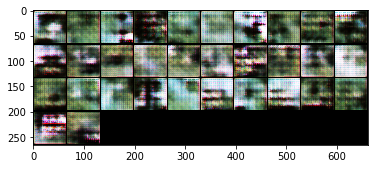

In [34]:
plt.imshow(fake001)

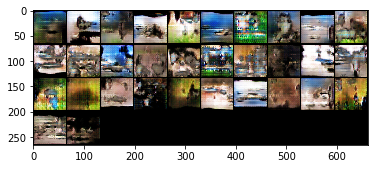

In [35]:
plt.imshow(fake100)

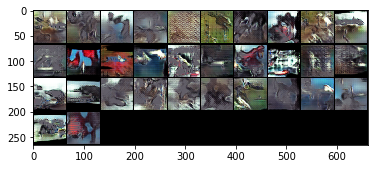

In [36]:
plt.imshow(fake200)